# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

We'll try to write some TensorFlow code to predict the price of Bitcoin based on the historical data of the Bitcoin itself.

## Get data
We're going to be using historical price data of BTC. Data has been downloaded from Yahoo Finance service.

In [1]:
# Import data with pandas
import pandas as pd

# Read in BTC data and pass the dates
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BTC-USD.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas that column 1 is datetime format

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [2]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-03,28680.494141,29259.533203,28178.388672,29006.308594,29006.308594,19122972518
2023-05-04,29031.304688,29353.185547,28694.039063,28847.710938,28847.710938,15548678514
2023-05-05,28851.480469,29668.908203,28845.509766,29534.384766,29534.384766,17936566518
2023-05-06,29538.859375,29820.126953,28468.966797,28904.623047,28904.623047,15913866714
2023-05-07,28916.708984,29151.941406,28788.570313,28897.636719,28897.636719,11557177344


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3155 entries, 2014-09-17 to 2023-05-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3155 non-null   float64
 1   High       3155 non-null   float64
 2   Low        3155 non-null   float64
 3   Close      3155 non-null   float64
 4   Adj Close  3155 non-null   float64
 5   Volume     3155 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 172.5 KB


In [4]:
# How many samples do we have?
len(df)

3155

In [5]:
# How many years is this?
3155/365

8.643835616438356

We've collected the historical price of BTC (from past 8,5 years or so) which gave exactly 3155 samples. 

Typically deep learning models thrive when being fed lots and lots of samples (where 'lots and lots' can be millions or more). 

A smaller number of samples is something you'll often run into while working with the time series problem.

> **NOTE**: The *seasonality* of a time series dataset is referred as the number of samples per year in given series. For our BTC data, it has seasonality of *daily* or value of *365* which speaks for itself.

In [6]:
# Only leave the closing price per each day
bitcoin_prices = pd.DataFrame(df['Close']).rename(columns={'Close': 'Price'})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-05-03,29006.308594
2023-05-04,28847.710938
2023-05-05,29534.384766


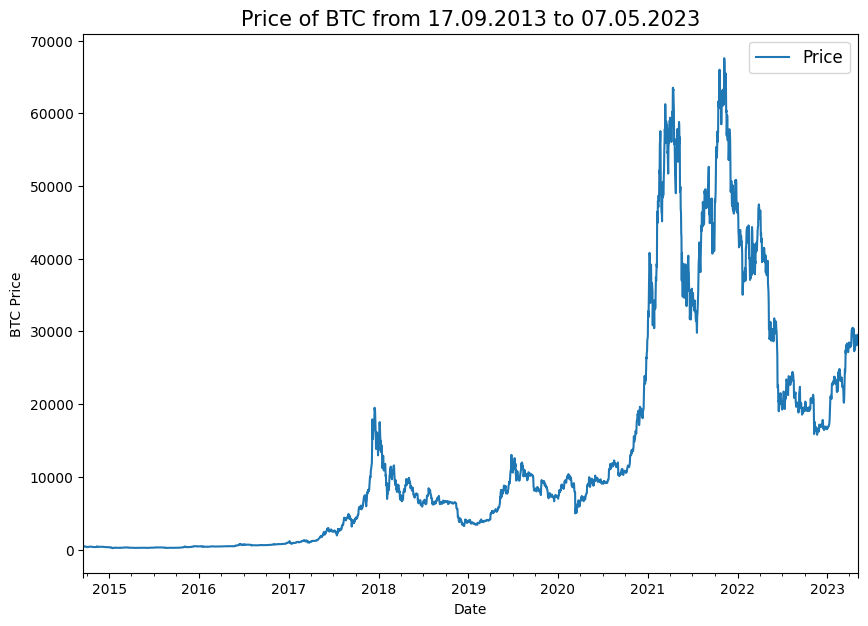

In [7]:
# Visualize the BTC price
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10,7))
plt.ylabel('BTC Price')
plt.title('Price of BTC from 17.09.2013 to 07.05.2023', fontsize=15)
plt.legend(fontsize=12)

## Importing time series data with Python's CSV module

In [8]:
# Importing and formatting data with Python CSV library
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/drive/MyDrive/Colab Notebooks/BTC-USD.csv", 'r') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=",")
  next(csv_reader) # goes through the iterator and ignores/skips next line - first line in our example
  
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates, not as strings
    btc_price.append(float(line[4])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

Text(0, 0.5, 'BTC price')

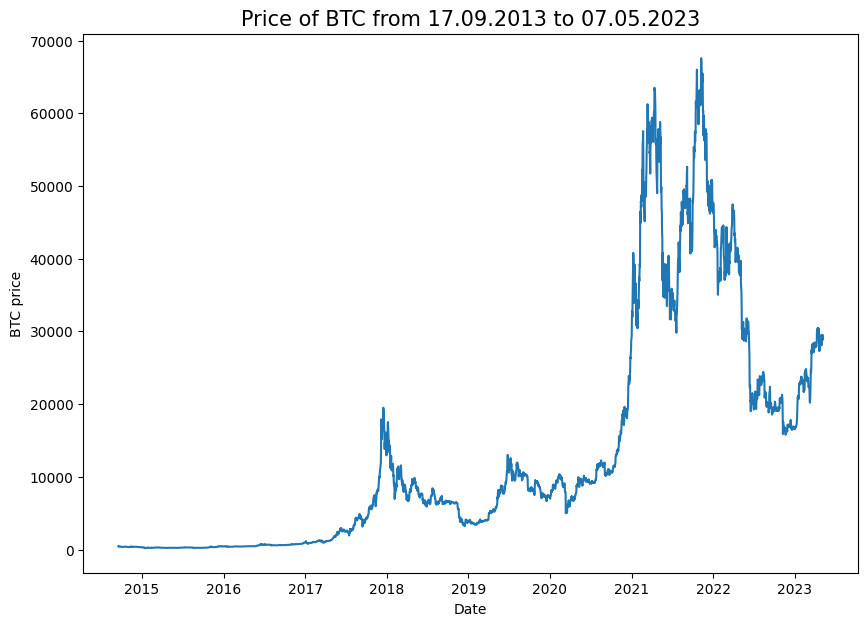

In [9]:
# Plot from Python CSV
import numpy as np

plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.title("Price of BTC from 17.09.2013 to 07.05.2023", fontsize=15)
plt.xlabel("Date")
plt.ylabel("BTC price")

## Format data part 1: Create train and test sets of our times series data

### Creating training and test sets with time series data (the wrong way)

In [10]:
# Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()
timesteps[:10], prices[:10]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
        '2014-09-23T00:00:00.000000000', '2014-09-24T00:00:00.000000000',
        '2014-09-25T00:00:00.000000000', '2014-09-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
        402.152008, 435.790985, 423.204987, 411.574005, 404.424988]))

In [11]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2524,), (631,), (2524,), (631,))

Text(0.5, 1.0, 'Comparison of train and test datasets')

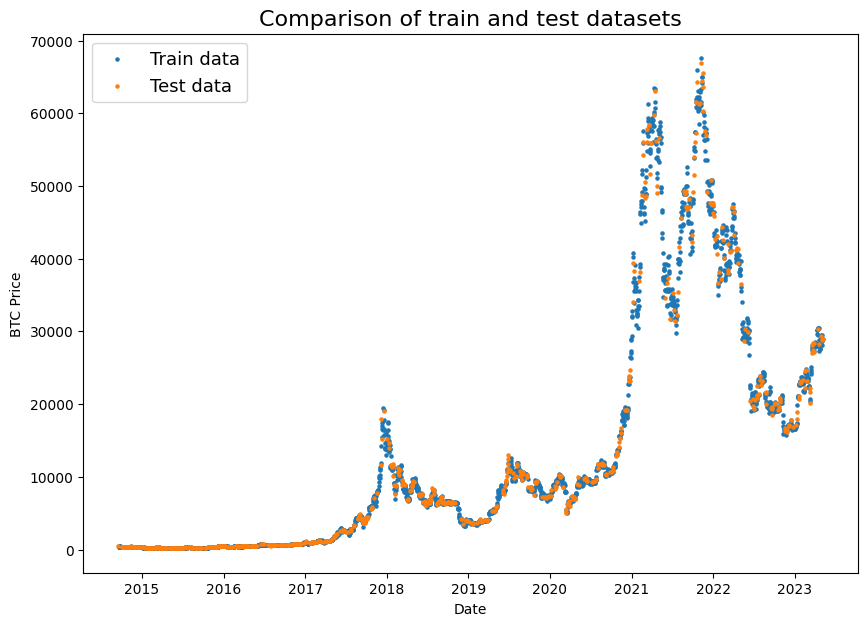

In [12]:
# Plotting wrong splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=13)
plt.title('Comparison of train and test datasets', fontsize=16)

### Create the train and test sets for time series (the proper way)

In [13]:
split_size = int(0.8 * len(prices)) # 80% test, 20% test; can be changed as needed

# Create proper splits
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2524, 631, 2524, 631)

Text(0.5, 1.0, 'Comparison of train and test datasets')

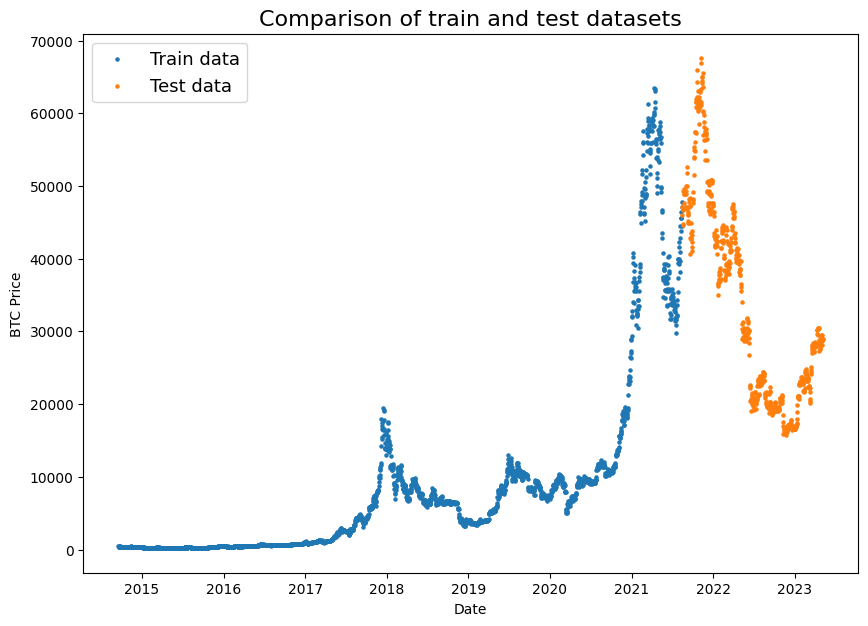

In [14]:
# Plot the correct splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=13)
plt.title('Comparison of train and test datasets', fontsize=16)

## Create a plotting function
As typing plotting code is tedious, it's time to functionize it.

In [15]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) againt values (a series of values across timesteps).

  Parameters:
  -----------
  timesteps : array of timestep values
  values : array of values across time
  format: style of plot, default "."
  start: where to start the plot (indexing from start of timesteps and values)
  end: same as above, but end
  label: label to show on plot about values, default None
  """
  # Plot the series
  #plt.figure(figsize=(10,7))
  plt.plot(timesteps[start:end],
           values[start:end],
           format,
           label=label)
  
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

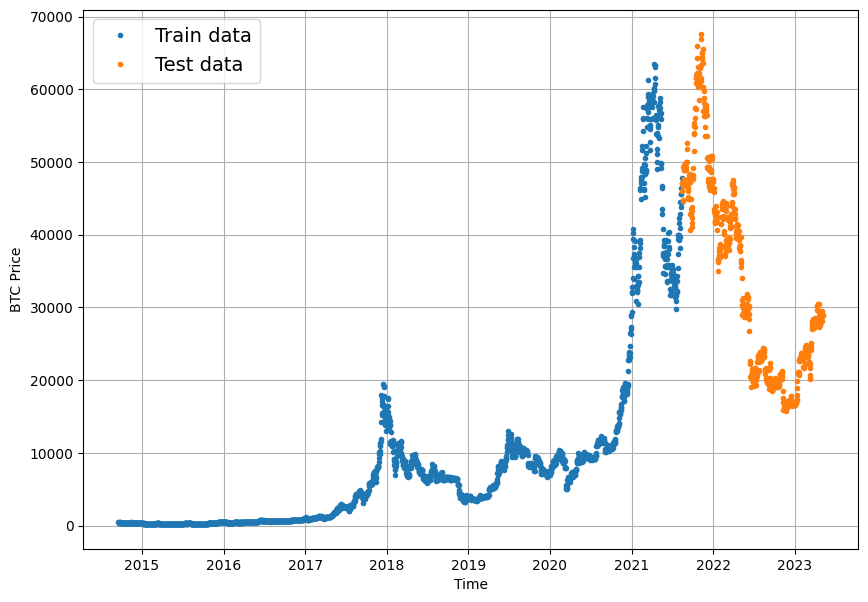

In [16]:
# Test the plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,
                 values=y_train,
                 label='Train data')
plot_time_series(timesteps=X_test,
                 values=y_test,
                 label='Test data')

## Modelling experiments

We've got some historical Bitcoin data. It's about time to note down the experiments we'd like to run.

Terms to be familiar with:
* *horizon* - steps into the future to predict
* *window size* - number of timestep to be used to predict the *horizon*

Experiments will be as follows:
0. Naive based model (baseline)
1. Dense model: horizon = 1, window = 7
2. Same as model 1: horizon = 1, window = 7
3. Same as model 1: horizon = 7, window = 30
4. Conv1D
5. LSTM
6. Same as model 1 (but with multivariate data)
7. N_BEATS algorithm
8. Ensemble (multiple models stacked together)
9. Future prediction model
10. Same as model 1 (but with turkey data introduced)

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

> The prediction at timestep **t** (y-hat) is equal to the value at timestep **t-1** (previous timestep) - this is for a horizon of 1.

Lecture for this section:
https://otexts.com/fpp3/simple-methods.html

In [17]:
# Creating a naive forecast 
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([47047.003906, 46004.484375, 44695.359375, 44801.1875  ,
        46717.578125, 49339.175781, 48905.492188, 49321.652344,
        49546.148438, 47706.117188]),
 array([29473.787109, 29340.261719, 29248.488281, 29268.806641,
        28091.568359, 28680.537109, 29006.308594, 28847.710938,
        29534.384766, 28904.623047]))

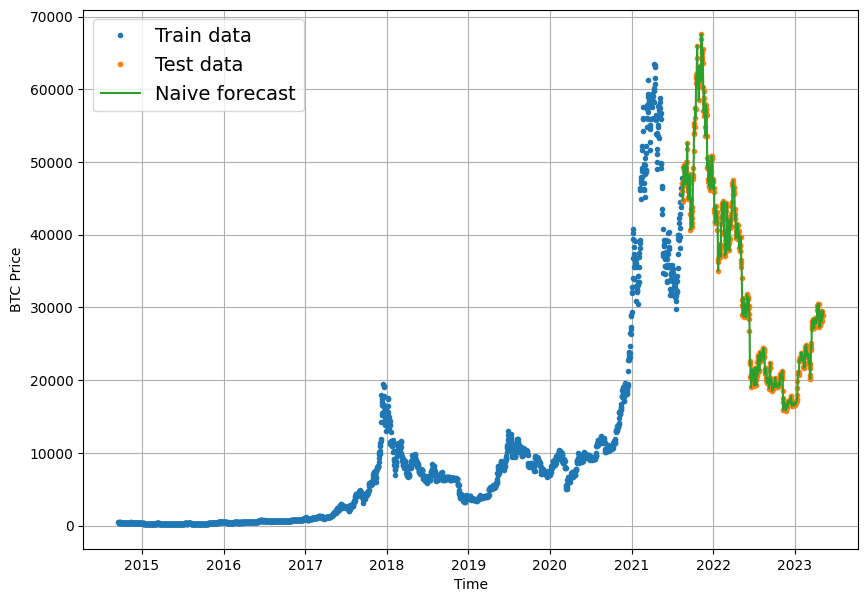

In [18]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', label='Naive forecast') # because of shapes, we need to cut the first value

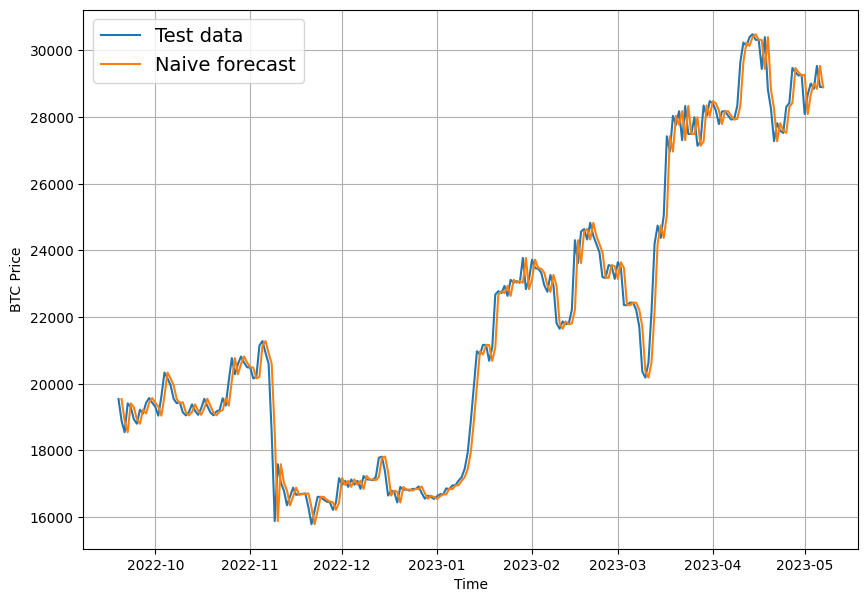

In [19]:
# Plot naive forecast - zoomed in version
plt.figure(figsize=(10, 7))
#plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, start=400, format='-', label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=400, format='-', label='Naive forecast') # because of shapes, we need to cut the first value

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing? 

Predicting a number, so that means our problem is a **regression** problem. 

Because we're working on a regression problem, we're going to need some regression-like metrics.

A few common regression metrics, which also can be use for time series forecasting, are:
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean sqaured error
* MAPE (sMAPE)- (scaled) mean absolute percentage error
* MASE - mean absolute scaled error

Main thing we're evaluating here is: **how do our model's forecast (`y_pred`) compare agains the actual values (`y_true`).**

### Creating MASE function

In [20]:
import tensorflow as tf

In [21]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE metric (assuming no seasonality of data).
  """

  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [22]:
mean_absolute_scaled_error(y_true=y_test[1:],
                           y_pred=naive_forecast).numpy()

1.0005690752533343

### Create a function for all of the metrics

In [23]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure data is float32 (default TensorFlow dtype)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true=y_true, y_pred=y_pred)

  # Return a dictionary
  return {'mae': mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape': mape.numpy(),
          'mase': mase.numpy()}

In [24]:
# Get the Naive forecast results
naive_results = evaluate_preds(y_true=y_test[1:], 
                               y_pred=naive_forecast)
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

In [25]:
# Average, min & max price
print(f"Average price: {tf.reduce_mean(y_test):.2f} USD") 
print(f"Minimum price: {tf.reduce_min(y_test):.2f} USD") 
print(f"Maximum price: {tf.reduce_max(y_test):.2f} USD")

Average price: 32882.82 USD
Minimum price: 15787.28 USD
Maximum price: 67566.83 USD


## Other model you can use for baselines and for actual forecasts
In this notebook, the main focus is on TensorFlow and building deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with:
https://github.com/mrdbourke/tensorflow-deep-learning#-10-time-series-fundamentals-and-milestone-project-3-bitpredict--exercises

## Format data part 2: Windowing our dataset
Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [26]:
# What we want to do with our BTC data
print(f"We want to use this: {btc_price[:7]} \nto predict this: {btc_price[7]}")

We want to use this: [457.334015, 424.440002, 394.79599, 408.903992, 398.821014, 402.152008, 435.790985] 
to predict this: 423.204987


In [27]:
# Setting up global variables for window and horizon size
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use past 7 days to make a prediction

In [28]:
# Create a function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Create labels for windowed dataset.

  E.g.:
    if horizon = 1:
      Input = [0, 1, 2, 3, 4, 5, 6, 7]
      Output = ([0, 1, 2, 3, 4, 5, 6], [7])
  """

  return x[:, :-horizon], x[:, -horizon:]

In [29]:
# Test the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data. However, it only works on a small scale.

We need the way to do the above across our entire time series...

We could do this with Python `for()` loops, however for large time series that would be quite slow.

To speed things up, we'll leverage `NumPy`'s array indexing.

The function will:
1. Create a windows step of a specific window size.
2. Use `Numpy` indexing to create 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]...]
```
3. Uses the 2D array of multiple window step to index on a target series. 
4. Uses our `get_labelled_windows()` function to turn the window steps into windows with a specifide horizon.

> **Resource**: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [30]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows
  of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (plus horizon)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window step (minus 1 to account for indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  #print(window_indexes, window_indexes.shape)

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  #print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [31]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(3148, 3148)

In [32]:
# View the first 3 windows and labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987]
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005]
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988]


In [33]:
# View the last 3 windows
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [29340.261719 29248.488281 29268.806641 28091.568359 28680.537109
 29006.308594 28847.710938] -> Label: [29534.384766]
Window: [29248.488281 29268.806641 28091.568359 28680.537109 29006.308594
 28847.710938 29534.384766] -> Label: [28904.623047]
Window: [29268.806641 28091.568359 28680.537109 29006.308594 28847.710938
 29534.384766 28904.623047] -> Label: [28897.636719]


> **NOTE**: There's a function that does similar to the above in `tf.keras.preprocessing`. You can try to replicate the above using said function.

Resource: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

In [34]:
# Another approach - data not separated as for window and horizon
sequence = tf.keras.utils.timeseries_dataset_from_array(data=prices,
                                                        targets=None,
                                                        sequence_length=8,
                                                        sequence_stride=1,
                                                        sampling_rate=1,
                                                        batch_size=32)

for batch in sequence:
  print(batch)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  587.801025 592.103027]
 [578.289001 575.04303  587.778015 592.690002 591.054016 587.801025
  592.103027 589.119995]
 [575.04303  587.778015 592.690002 591.054016 587.801025 592.103027
  589.119995 587.559021]
 [587.778015 592.690002 591.054016 587.801025 592.103027 589.119995
  587.559021 585.588013]
 [592.690002 591.054016 587.801025 592.103027 589.119995 587.559021
  585.588013 570.473022]
 [591.054016 587.801025 592.103027 589.119995 587.559021 585.588013
  570.473022 567.23999 ]
 [587.801025 592.103027 589.119995 587.559021 585.588013 570.473022
  567.23999  577.439026]
 [592.103027 589.119995 587.559021 585.588013 570.473022 567.23999
  577.439026 573.216003]
 [589.119995 587.559021 585.588013 570.473022 567.23999  577.439026
  573.216003 574.317993]
 [587.559021 585.588013 570.473022 567.23999  577.439026 573.216003
  574.317993 575.630005]
 [585.588013 570.473022 567.23999  577.439026 573.216003 574.317993
  575.

In [35]:
# Another approach pt.2 - data separated as for window and horizon
input_data = prices[:-6]
targets = prices[7:]

sequence = tf.keras.utils.timeseries_dataset_from_array(data=input_data,
                                                        targets=targets,
                                                        sampling_rate=1,
                                                        sequence_length=7,
                                                        sequence_stride=1,
                                                        batch_size=32)


for batch in sequence:
  inputs, targets = batch
  #assert np.array_equal(inputs[0], prices[:7])
  #assert np.array_equal(targets[0], prices[7])
  #break
  print(inputs[1], targets[1])
print(prices[-10:])

tf.Tensor(
[424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987], shape=(7,), dtype=float64) tf.Tensor(411.574005, shape=(), dtype=float64)
tf.Tensor(
[382.845001 386.475006 383.15799  358.416992 358.345001 347.270996
 354.70401 ], shape=(7,), dtype=float64) tf.Tensor(352.989014, shape=(), dtype=float64)
tf.Tensor(
[350.847992 352.920013 367.572998 376.901001 375.347992 368.369995
 369.670013], shape=(7,), dtype=float64) tf.Tensor(376.446991, shape=(), dtype=float64)
tf.Tensor(
[334.571991 322.533997 319.007996 327.924011 315.863007 317.239014
 312.670013], shape=(7,), dtype=float64) tf.Tensor(310.737, shape=(), dtype=float64)
tf.Tensor(
[247.847    253.718002 273.472992 263.475006 233.914993 233.513
 226.425003], shape=(7,), dtype=float64) tf.Tensor(217.464005, shape=(), dtype=float64)
tf.Tensor(
[237.470001 236.425995 253.828003 254.263    260.201996 275.670013
 281.701996], shape=(7,), dtype=float64) tf.Tensor(273.09201, shape=(), dtype=float64)
tf.Tensor(


## Turning windows into training and test datasets

In [36]:
# Make the splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Split matching pairs of windows and labels into test and train
  datasets.
  """
  split_size = int(len(windows) * (1 - test_split)) # default to 80% train / 20% test

  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [37]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2518, 630, 2518, 630)

In [38]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]),
 array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

In [39]:
# Chech to see if the train labels are the same (before and after the split)
np.array_equal(np.squeeze(train_labels[:-HORIZON]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate, `ModelCheckpoint` is quite useful. This way we can compare apples to apples.

More specifically, we want to compare each of our model's best perfoemance against the other model's best performance.

For example, if our model performs best on epoch 55, but the training is for 100 epochs, we'd like to load and evaluate the model on the best epoch there was.


In [40]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path='model_experiments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=1,
                                            save_best_only=True,
                                            monitor='val_loss')

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 units and ReLU activation funciton
* An output layer with a linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size = 128 (previously we've used 32)
* Epochs = 100

Why these values? They were picked out of experimenation.

* **Hyperparameters** = values a machine learning practitioner can adjust themselves.
* **Parameters** = values a model learns on its own.

In [41]:
import tensorflow as tf
from tensorflow.keras import layers

# Set the random seed
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear') # linear = no activation
], name='model_1_dense') # model name so we can save it

# 2. Compile the model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# 3. Fit the model
history_model_1 = model_1.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              verbose=1,
                              #batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
77/79 [============================>.] - ETA: 0s - loss: 2672.2563 - mae: 2672.2563 - mse: 63003440.0000
Epoch 1: val_loss improved from inf to 1749.93091, saving model to model_experiments/model_1_dense


79/79 [==============================] - 11s 37ms/step - loss: 2626.5132 - mae: 2626.5132 - mse: 61675284.0000 - val_loss: 1749.9309 - val_mae: 1749.9309 - val_mse: 5223480.0000
Epoch 2/100
72/79 [==========================>...] - ETA: 0s - loss: 378.8505 - mae: 378.8505 - mse: 803952.6875
Epoch 2: val_loss improved from 1749.93091 to 1008.81610, saving model to model_experiments/model_1_dense


79/79 [==============================] - 2s 26ms/step - loss: 375.9079 - mae: 375.9079 - mse: 778087.3750 - val_loss: 1008.8161 - val_mae: 1008.8161 - val_mse: 2177005.7500
Epoch 3/100
68/79 [========================>.....] - ETA: 0s - loss: 367.2668 - mae: 367.2668 - mse: 748420.9375
Epoch 3: val_loss improved from 1008.81610 to 965.68860, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 360.2143 - mae: 360.2143 - mse: 712263.5000 - val_loss: 965.6886 - val_mae: 965.6886 - val_mse: 2011896.6250
Epoch 4/100
64/79 [=======================>......] - ETA: 0s - loss: 323.7304 - mae: 323.7304 - mse: 564589.8750
Epoch 4: val_loss did not improve from 965.68860
79/79 [==============================] - 0s 4ms/step - loss: 335.8149 - mae: 335.8149 - mse: 645258.4375 - val_loss: 1247.4131 - val_mae: 1247.4131 - val_mse: 3015158.5000
Epoch 5/100
65/79 [=======================>......] - ETA: 0s - loss: 368.1042 - mae: 368.1042 - mse: 734836.5000
Epoch 5: val_loss improved from 965.68860 to 918.41986, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 361.5096 - mae: 361.5096 - mse: 714011.1250 - val_loss: 918.4199 - val_mae: 918.4199 - val_mse: 1839930.7500
Epoch 6/100
63/79 [======================>.......] - ETA: 0s - loss: 328.6437 - mae: 328.6437 - mse: 616393.2500
Epoch 6: val_loss did not improve from 918.41986
79/79 [==============================] - 0s 4ms/step - loss: 336.4558 - mae: 336.4558 - mse: 632465.8125 - val_loss: 1061.5747 - val_mae: 1061.5747 - val_mse: 2329792.5000
Epoch 7/100
70/79 [=========================>....] - ETA: 0s - loss: 323.7179 - mae: 323.7179 - mse: 604528.1250
Epoch 7: val_loss did not improve from 918.41986
79/79 [==============================] - 0s 4ms/step - loss: 319.8862 - mae: 319.8862 - mse: 581455.6875 - val_loss: 1151.9792 - val_mae: 1151.9792 - val_mse: 2622150.0000
Epoch 8/100
69/79 [=========================>....] - ETA: 0s - loss: 325.8191 - mae: 325.8191 - mse: 575806.0000
Epoch 8: val_loss improved from 918.41986 to 907

79/79 [==============================] - 1s 10ms/step - loss: 318.8519 - mae: 318.8519 - mse: 555848.8750 - val_loss: 907.9226 - val_mae: 907.9226 - val_mse: 1816071.3750
Epoch 9/100
68/79 [========================>.....] - ETA: 0s - loss: 321.0510 - mae: 321.0510 - mse: 534750.6250
Epoch 9: val_loss did not improve from 907.92261
79/79 [==============================] - 0s 4ms/step - loss: 323.5327 - mae: 323.5327 - mse: 580502.7500 - val_loss: 938.5311 - val_mae: 938.5311 - val_mse: 1826392.3750
Epoch 10/100
69/79 [=========================>....] - ETA: 0s - loss: 329.7820 - mae: 329.7820 - mse: 593240.3750
Epoch 10: val_loss did not improve from 907.92261
79/79 [==============================] - 0s 4ms/step - loss: 328.1158 - mae: 328.1158 - mse: 583853.3125 - val_loss: 912.3307 - val_mae: 912.3307 - val_mse: 1824596.8750
Epoch 11/100
69/79 [=========================>....] - ETA: 0s - loss: 300.8069 - mae: 300.8069 - mse: 514510.7812
Epoch 11: val_loss improved from 907.92261 to 902

79/79 [==============================] - 1s 10ms/step - loss: 303.5634 - mae: 303.5634 - mse: 521506.9375 - val_loss: 902.9675 - val_mae: 902.9675 - val_mse: 1793193.6250
Epoch 12/100
69/79 [=========================>....] - ETA: 0s - loss: 317.2067 - mae: 317.2067 - mse: 550093.0625
Epoch 12: val_loss did not improve from 902.96753
79/79 [==============================] - 0s 4ms/step - loss: 313.2137 - mae: 313.2137 - mse: 553233.5625 - val_loss: 1123.9033 - val_mae: 1123.9033 - val_mse: 2469906.7500
Epoch 13/100
76/79 [===========================>..] - ETA: 0s - loss: 296.9214 - mae: 296.9214 - mse: 514220.0938
Epoch 13: val_loss improved from 902.96753 to 856.60022, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 298.7268 - mae: 298.7268 - mse: 530328.9375 - val_loss: 856.6002 - val_mae: 856.6002 - val_mse: 1650689.0000
Epoch 14/100
69/79 [=========================>....] - ETA: 0s - loss: 317.6385 - mae: 317.6385 - mse: 560134.0000
Epoch 14: val_loss did not improve from 856.60022
79/79 [==============================] - 0s 4ms/step - loss: 320.4263 - mae: 320.4263 - mse: 582087.1250 - val_loss: 1256.3922 - val_mae: 1256.3922 - val_mse: 2919532.7500
Epoch 15/100
68/79 [========================>.....] - ETA: 0s - loss: 305.2722 - mae: 305.2722 - mse: 533627.3750
Epoch 15: val_loss improved from 856.60022 to 856.57153, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 301.0305 - mae: 301.0305 - mse: 523391.9062 - val_loss: 856.5715 - val_mae: 856.5715 - val_mse: 1619579.3750
Epoch 16/100
71/79 [=========================>....] - ETA: 0s - loss: 301.5889 - mae: 301.5889 - mse: 513051.9375
Epoch 16: val_loss did not improve from 856.57153
79/79 [==============================] - 0s 4ms/step - loss: 303.4441 - mae: 303.4441 - mse: 530651.7500 - val_loss: 875.2090 - val_mae: 875.2090 - val_mse: 1654700.2500
Epoch 17/100
69/79 [=========================>....] - ETA: 0s - loss: 310.7725 - mae: 310.7725 - mse: 546616.5000
Epoch 17: val_loss improved from 856.57153 to 847.58167, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 13ms/step - loss: 306.7451 - mae: 306.7451 - mse: 525791.1875 - val_loss: 847.5817 - val_mae: 847.5817 - val_mse: 1626966.5000
Epoch 18/100
66/79 [========================>.....] - ETA: 0s - loss: 301.8195 - mae: 301.8195 - mse: 535658.1875
Epoch 18: val_loss did not improve from 847.58167
79/79 [==============================] - 0s 4ms/step - loss: 296.7600 - mae: 296.7600 - mse: 519783.5938 - val_loss: 853.9015 - val_mae: 853.9015 - val_mse: 1644470.0000
Epoch 19/100
67/79 [========================>.....] - ETA: 0s - loss: 313.3996 - mae: 313.3996 - mse: 558994.1250
Epoch 19: val_loss did not improve from 847.58167
79/79 [==============================] - 0s 4ms/step - loss: 307.7002 - mae: 307.7002 - mse: 528595.8125 - val_loss: 945.1749 - val_mae: 945.1749 - val_mse: 1883325.0000
Epoch 20/100
72/79 [==========================>...] - ETA: 0s - loss: 327.5551 - mae: 327.5551 - mse: 622360.8125
Epoch 20: val_loss did not improve from 847.581

79/79 [==============================] - 1s 11ms/step - loss: 282.1946 - mae: 282.1946 - mse: 481199.9375 - val_loss: 813.2841 - val_mae: 813.2841 - val_mse: 1534594.5000
Epoch 31/100
76/79 [===========================>..] - ETA: 0s - loss: 279.4152 - mae: 279.4152 - mse: 461908.0000
Epoch 31: val_loss improved from 813.28412 to 805.66113, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 277.9825 - mae: 277.9825 - mse: 458517.5938 - val_loss: 805.6611 - val_mae: 805.6611 - val_mse: 1494516.3750
Epoch 32/100
73/79 [==========================>...] - ETA: 0s - loss: 274.0127 - mae: 274.0127 - mse: 467343.6562
Epoch 32: val_loss improved from 805.66113 to 799.12708, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 9ms/step - loss: 276.5741 - mae: 276.5741 - mse: 462713.8438 - val_loss: 799.1271 - val_mae: 799.1271 - val_mse: 1492929.6250
Epoch 33/100
77/79 [============================>.] - ETA: 0s - loss: 297.1176 - mae: 297.1176 - mse: 510313.8750
Epoch 33: val_loss did not improve from 799.12708
79/79 [==============================] - 0s 5ms/step - loss: 295.6074 - mae: 295.6074 - mse: 507133.8125 - val_loss: 1041.7565 - val_mae: 1041.7565 - val_mse: 2051597.3750
Epoch 34/100
66/79 [========================>.....] - ETA: 0s - loss: 305.9613 - mae: 305.9613 - mse: 533851.2500
Epoch 34: val_loss did not improve from 799.12708
79/79 [==============================] - 0s 4ms/step - loss: 308.6698 - mae: 308.6698 - mse: 552556.5000 - val_loss: 1253.0199 - val_mae: 1253.0199 - val_mse: 2695014.0000
Epoch 35/100
69/79 [=========================>....] - ETA: 0s - loss: 286.7497 - mae: 286.7497 - mse: 514004.0625
Epoch 35: val_loss did not improve from 799.

79/79 [==============================] - 1s 10ms/step - loss: 274.7435 - mae: 274.7435 - mse: 460946.3125 - val_loss: 794.1671 - val_mae: 794.1671 - val_mse: 1477708.1250
Epoch 41/100
69/79 [=========================>....] - ETA: 0s - loss: 278.4689 - mae: 278.4689 - mse: 453075.5625
Epoch 41: val_loss did not improve from 794.16711
79/79 [==============================] - 0s 4ms/step - loss: 280.4973 - mae: 280.4973 - mse: 483027.3125 - val_loss: 796.5717 - val_mae: 796.5717 - val_mse: 1486704.5000
Epoch 42/100
72/79 [==========================>...] - ETA: 0s - loss: 275.5468 - mae: 275.5468 - mse: 471349.5000
Epoch 42: val_loss did not improve from 794.16711
79/79 [==============================] - 0s 4ms/step - loss: 274.2866 - mae: 274.2866 - mse: 465449.3750 - val_loss: 797.3719 - val_mae: 797.3719 - val_mse: 1467873.3750
Epoch 43/100
66/79 [========================>.....] - ETA: 0s - loss: 285.9333 - mae: 285.9333 - mse: 503336.8438
Epoch 43: val_loss improved from 794.16711 to 7

79/79 [==============================] - 1s 10ms/step - loss: 279.2096 - mae: 279.2096 - mse: 470532.6875 - val_loss: 793.7001 - val_mae: 793.7001 - val_mse: 1480291.6250
Epoch 44/100
68/79 [========================>.....] - ETA: 0s - loss: 275.6829 - mae: 275.6829 - mse: 440983.2500
Epoch 44: val_loss did not improve from 793.70013
79/79 [==============================] - 0s 4ms/step - loss: 283.8665 - mae: 283.8665 - mse: 480849.4375 - val_loss: 917.3854 - val_mae: 917.3854 - val_mse: 1779544.6250
Epoch 45/100
72/79 [==========================>...] - ETA: 0s - loss: 291.2960 - mae: 291.2960 - mse: 498139.1250
Epoch 45: val_loss did not improve from 793.70013
79/79 [==============================] - 0s 4ms/step - loss: 299.8073 - mae: 299.8073 - mse: 522062.2188 - val_loss: 937.4827 - val_mae: 937.4827 - val_mse: 1763807.2500
Epoch 46/100
69/79 [=========================>....] - ETA: 0s - loss: 282.9307 - mae: 282.9307 - mse: 491490.6562
Epoch 46: val_loss did not improve from 793.700

79/79 [==============================] - 1s 13ms/step - loss: 277.8159 - mae: 277.8159 - mse: 478012.2812 - val_loss: 781.0930 - val_mae: 781.0930 - val_mse: 1438084.3750
Epoch 62/100
70/79 [=========================>....] - ETA: 0s - loss: 292.5662 - mae: 292.5662 - mse: 528865.6250
Epoch 62: val_loss did not improve from 781.09302
79/79 [==============================] - 0s 4ms/step - loss: 286.4054 - mae: 286.4054 - mse: 503084.5938 - val_loss: 788.9430 - val_mae: 788.9430 - val_mse: 1441831.8750
Epoch 63/100
71/79 [=========================>....] - ETA: 0s - loss: 260.7187 - mae: 260.7187 - mse: 410777.3438
Epoch 63: val_loss did not improve from 781.09302
79/79 [==============================] - 0s 4ms/step - loss: 274.1446 - mae: 274.1446 - mse: 465395.4062 - val_loss: 843.9461 - val_mae: 843.9461 - val_mse: 1589256.1250
Epoch 64/100
71/79 [=========================>....] - ETA: 0s - loss: 271.1888 - mae: 271.1888 - mse: 463804.5938
Epoch 64: val_loss did not improve from 781.093

79/79 [==============================] - 1s 10ms/step - loss: 272.0465 - mae: 272.0465 - mse: 448930.4062 - val_loss: 779.7288 - val_mae: 779.7288 - val_mse: 1429008.5000
Epoch 71/100
72/79 [==========================>...] - ETA: 0s - loss: 276.2232 - mae: 276.2232 - mse: 466235.0000
Epoch 71: val_loss did not improve from 779.72876
79/79 [==============================] - 0s 4ms/step - loss: 274.0144 - mae: 274.0144 - mse: 465026.7500 - val_loss: 781.7809 - val_mae: 781.7809 - val_mse: 1441112.3750
Epoch 72/100
77/79 [============================>.] - ETA: 0s - loss: 281.3481 - mae: 281.3481 - mse: 453017.1875
Epoch 72: val_loss did not improve from 779.72876
79/79 [==============================] - 0s 4ms/step - loss: 284.0448 - mae: 284.0448 - mse: 466080.6875 - val_loss: 1139.3134 - val_mae: 1139.3134 - val_mse: 2425122.2500
Epoch 73/100
68/79 [========================>.....] - ETA: 0s - loss: 282.8664 - mae: 282.8664 - mse: 485243.7812
Epoch 73: val_loss did not improve from 779.7

79/79 [==============================] - 1s 10ms/step - loss: 295.9271 - mae: 295.9271 - mse: 483804.6250 - val_loss: 779.4057 - val_mae: 779.4057 - val_mse: 1431873.2500
Epoch 84/100
69/79 [=========================>....] - ETA: 0s - loss: 266.1495 - mae: 266.1495 - mse: 433456.7500
Epoch 84: val_loss did not improve from 779.40570
79/79 [==============================] - 0s 4ms/step - loss: 271.9153 - mae: 271.9153 - mse: 446342.8750 - val_loss: 793.6328 - val_mae: 793.6328 - val_mse: 1467184.0000
Epoch 85/100
66/79 [========================>.....] - ETA: 0s - loss: 268.2335 - mae: 268.2335 - mse: 441746.0000
Epoch 85: val_loss did not improve from 779.40570
79/79 [==============================] - 0s 4ms/step - loss: 264.6575 - mae: 264.6575 - mse: 433542.1562 - val_loss: 798.3867 - val_mae: 798.3867 - val_mse: 1450869.3750
Epoch 86/100
68/79 [========================>.....] - ETA: 0s - loss: 291.1800 - mae: 291.1800 - mse: 505984.9375
Epoch 86: val_loss did not improve from 779.405

79/79 [==============================] - 1s 14ms/step - loss: 275.3870 - mae: 275.3870 - mse: 464055.0625 - val_loss: 776.8298 - val_mae: 776.8298 - val_mse: 1422676.5000
Epoch 91/100
71/79 [=========================>....] - ETA: 0s - loss: 291.4609 - mae: 291.4609 - mse: 486380.9688
Epoch 91: val_loss did not improve from 776.82977
79/79 [==============================] - 0s 6ms/step - loss: 288.9514 - mae: 288.9514 - mse: 500990.8438 - val_loss: 776.9461 - val_mae: 776.9461 - val_mse: 1425870.2500
Epoch 92/100
71/79 [=========================>....] - ETA: 0s - loss: 269.2857 - mae: 269.2857 - mse: 428264.0312
Epoch 92: val_loss did not improve from 776.82977
79/79 [==============================] - 0s 6ms/step - loss: 272.4215 - mae: 272.4215 - mse: 444019.6875 - val_loss: 777.1243 - val_mae: 777.1243 - val_mse: 1420106.3750
Epoch 93/100
72/79 [==========================>...] - ETA: 0s - loss: 277.2111 - mae: 277.2111 - mse: 485770.8438
Epoch 93: val_loss did not improve from 776.829

In [42]:
# Evaluate the model
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 853.7904 - mae: 853.7904 - mse: 1552701.0000


[853.7904052734375, 853.7904052734375, 1552701.0]

In [43]:
# Load in the saved, best performat model
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 776.8298 - mae: 776.8298 - mse: 1422676.5000


[776.8297729492188, 776.8297729492188, 1422676.5]

### Make forecasts with a model (on the test dataset)

To make 'forecasts' on the test dataset, let's write a function to:
1. Takes in a trained model
2. Takes in some input data
3. Passes the input to the `predict()` method
4. Returns the predictions

In [44]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # 1D array of preds as output

In [45]:
# Make predictions using model_1
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10], len(model_1_preds)

20/20 [==============================] - 0s 2ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([47051.395, 46231.645, 44714.43 , 44735.965, 46347.867, 49034.24 ,
        49107.13 , 49396.863, 49639.89 , 47964.605], dtype=float32)>,
 630)

In [46]:
# Shapes had to be changes 
test_labels.shape, model_1_preds.shape

((630, 1), TensorShape([630]))

In [47]:
# Evaluate our preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 776.82983,
 'mse': 1422676.4,
 'rmse': 1192.76,
 'mape': 2.286696,
 'mase': 1.0122947}

In [48]:
# Naive results
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

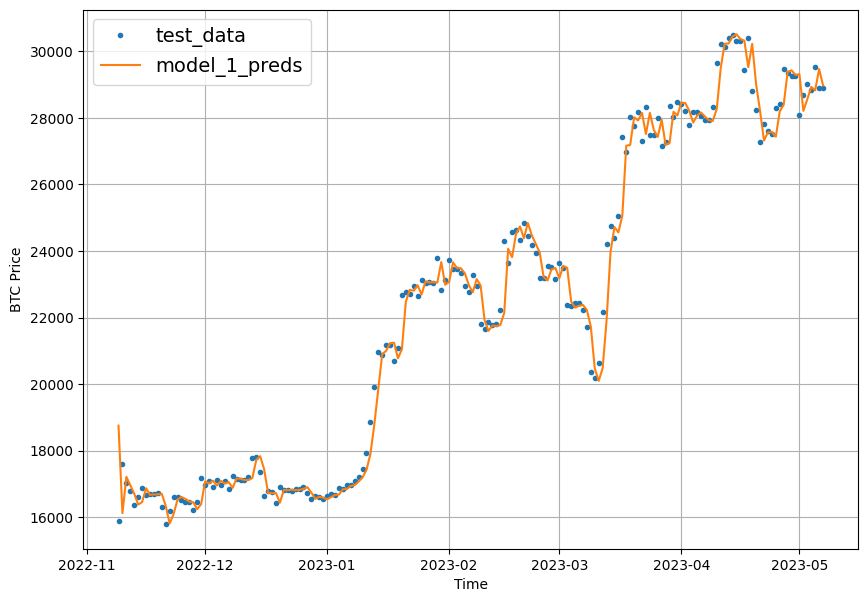

In [49]:
# Let's plot model_1 predictions 
offset=450
plt.figure(figsize=(10,7))

# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_1_preds, 
                 format="-",
                 start=offset, 
                 label='model_1_preds')

## Model 2: Dense (window = 30, horizon = 1)

In [50]:
# Update global variables
HORIZON = 1
WINDOW_SIZE = 30

In [51]:
# Make window data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3125, 3125)

In [52]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2500, 625, 2500, 625)

In [53]:
train_windows[:3], train_labels[:3]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005, 404.424988, 399.519989, 377.181   ,
         375.46701 , 386.944   ,

In [54]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_2_dense')

# Compile the model
model_2.compile(loss='mae',
                optimizer='adam',
                metrics=['mse', 'mae'])

# Fit the model
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])


Epoch 1: val_loss improved from inf to 4327.02393, saving model to model_experiments/model_2_dense



Epoch 2: val_loss improved from 4327.02393 to 2468.48730, saving model to model_experiments/model_2_dense



Epoch 3: val_loss improved from 2468.48730 to 1569.63135, saving model to model_experiments/model_2_dense



Epoch 4: val_loss did not improve from 1569.63135

Epoch 5: val_loss improved from 1569.63135 to 1342.19543, saving model to model_experiments/model_2_dense



Epoch 6: val_loss did not improve from 1342.19543

Epoch 7: val_loss improved from 1342.19543 to 1254.90552, saving model to model_experiments/model_2_dense



Epoch 8: val_loss did not improve from 1254.90552

Epoch 9: val_loss did not improve from 1254.90552

Epoch 10: val_loss improved from 1254.90552 to 1183.18738, saving model to model_experiments/model_2_dense



Epoch 11: val_loss did not improve from 1183.18738

Epoch 12: val_loss improved from 1183.18738 to 1114.24500, saving model to model_experiments/model_2_dense



Epoch 13: val_loss did not improve from 1114.24500

Epoch 14: val_loss did not improve from 1114.24500

Epoch 15: val_loss did not improve from 1114.24500

Epoch 16: val_loss improved from 1114.24500 to 1036.10425, saving model to model_experiments/model_2_dense



Epoch 17: val_loss did not improve from 1036.10425

Epoch 18: val_loss did not improve from 1036.10425

Epoch 19: val_loss did not improve from 1036.10425

Epoch 20: val_loss improved from 1036.10425 to 993.46863, saving model to model_experiments/model_2_dense



Epoch 21: val_loss did not improve from 993.46863

Epoch 22: val_loss did not improve from 993.46863

Epoch 23: val_loss did not improve from 993.46863

Epoch 24: val_loss did not improve from 993.46863

Epoch 25: val_loss did not improve from 993.46863

Epoch 26: val_loss improved from 993.46863 to 954.79840, saving model to model_experiments/model_2_dense



Epoch 27: val_loss did not improve from 954.79840

Epoch 28: val_loss did not improve from 954.79840

Epoch 29: val_loss did not improve from 954.79840

Epoch 30: val_loss did not improve from 954.79840

Epoch 31: val_loss did not improve from 954.79840

Epoch 32: val_loss did not improve from 954.79840

Epoch 33: val_loss improved from 954.79840 to 931.11267, saving model to model_experiments/model_2_dense



Epoch 34: val_loss did not improve from 931.11267

Epoch 35: val_loss did not improve from 931.11267

Epoch 36: val_loss did not improve from 931.11267

Epoch 37: val_loss did not improve from 931.11267

Epoch 38: val_loss did not improve from 931.11267

Epoch 39: val_loss improved from 931.11267 to 888.78363, saving model to model_experiments/model_2_dense



Epoch 40: val_loss did not improve from 888.78363

Epoch 41: val_loss did not improve from 888.78363

Epoch 42: val_loss did not improve from 888.78363

Epoch 43: val_loss did not improve from 888.78363

Epoch 44: val_loss did not improve from 888.78363

Epoch 45: val_loss did not improve from 888.78363

Epoch 46: val_loss did not improve from 888.78363

Epoch 47: val_loss did not improve from 888.78363

Epoch 48: val_loss improved from 888.78363 to 878.56677, saving model to model_experiments/model_2_dense



Epoch 49: val_loss did not improve from 878.56677

Epoch 50: val_loss did not improve from 878.56677

Epoch 51: val_loss did not improve from 878.56677

Epoch 52: val_loss did not improve from 878.56677

Epoch 53: val_loss did not improve from 878.56677

Epoch 54: val_loss did not improve from 878.56677

Epoch 55: val_loss did not improve from 878.56677

Epoch 56: val_loss did not improve from 878.56677

Epoch 57: val_loss did not improve from 878.56677

Epoch 58: val_loss improved from 878.56677 to 857.55988, saving model to model_experiments/model_2_dense



Epoch 59: val_loss did not improve from 857.55988

Epoch 60: val_loss did not improve from 857.55988

Epoch 61: val_loss did not improve from 857.55988

Epoch 62: val_loss did not improve from 857.55988

Epoch 63: val_loss did not improve from 857.55988

Epoch 64: val_loss improved from 857.55988 to 843.85168, saving model to model_experiments/model_2_dense



Epoch 65: val_loss did not improve from 843.85168

Epoch 66: val_loss did not improve from 843.85168

Epoch 67: val_loss did not improve from 843.85168

Epoch 68: val_loss did not improve from 843.85168

Epoch 69: val_loss did not improve from 843.85168

Epoch 70: val_loss did not improve from 843.85168

Epoch 71: val_loss did not improve from 843.85168

Epoch 72: val_loss did not improve from 843.85168

Epoch 73: val_loss did not improve from 843.85168

Epoch 74: val_loss did not improve from 843.85168

Epoch 75: val_loss did not improve from 843.85168

Epoch 76: val_loss did not improve from 843.85168

Epoch 77: val_loss did not improve from 843.85168

Epoch 78: val_loss did not improve from 843.85168

Epoch 79: val_loss did not improve from 843.85168

Epoch 80: val_loss did not improve from 843.85168

Epoch 81: val_loss did not improve from 843.85168

Epoch 82: val_loss did not improve from 843.85168

Epoch 83: val_loss did not improve from 843.85168

Epoch 84: val_loss did not imp


Epoch 86: val_loss did not improve from 842.12012

Epoch 87: val_loss did not improve from 842.12012

Epoch 88: val_loss improved from 842.12012 to 839.35181, saving model to model_experiments/model_2_dense



Epoch 89: val_loss did not improve from 839.35181

Epoch 90: val_loss did not improve from 839.35181

Epoch 91: val_loss improved from 839.35181 to 837.29657, saving model to model_experiments/model_2_dense



Epoch 92: val_loss did not improve from 837.29657

Epoch 93: val_loss improved from 837.29657 to 827.80316, saving model to model_experiments/model_2_dense



Epoch 94: val_loss did not improve from 827.80316

Epoch 95: val_loss did not improve from 827.80316

Epoch 96: val_loss did not improve from 827.80316

Epoch 97: val_loss did not improve from 827.80316

Epoch 98: val_loss did not improve from 827.80316

Epoch 99: val_loss did not improve from 827.80316

Epoch 100: val_loss did not improve from 827.80316


In [55]:
# Evaluate model_2 on test data
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 883.8509 - mse: 1646429.2500 - mae: 883.8509


[883.8508911132812, 1646429.25, 883.8508911132812]

In [56]:
# Load in the best performant model_2
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense')
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 827.8032 - mse: 1532960.7500 - mae: 827.8032


[827.80322265625, 1532960.75, 827.80322265625]

In [57]:
# Get the forecast predicions
model_2_preds = make_preds(model_2, test_windows)

20/20 [==============================] - 0s 2ms/step


In [58]:
# Evaluate results for model_2 prediction
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 827.8032,
 'mse': 1532960.8,
 'rmse': 1238.1279,
 'mape': 2.4532795,
 'mase': 1.0844928}

In [59]:
model_1_results

{'mae': 776.82983,
 'mse': 1422676.4,
 'rmse': 1192.76,
 'mape': 2.286696,
 'mase': 1.0122947}

In [60]:
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

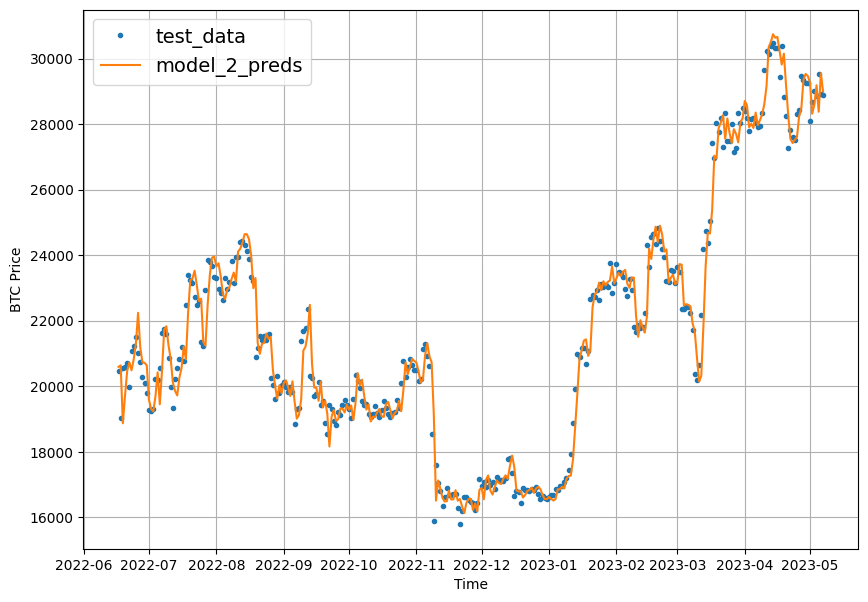

In [61]:
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_2_preds,
                 start=offset,
                 format="-",
                 label='model_2_preds')

## Model 3: Dense (window = 30, horizon = 7)

In [62]:
# Update global variables
HORIZON = 7
WINDOW_SIZE = 30

In [63]:
# Create new windows
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(3119, 3119)

In [64]:
# Make train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,
                                                                                full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2495, 624, 2495, 624)

In [65]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

# Compile the model
model_3.compile(loss='mae',
                optimizer='adam',
                metrics=['mae', 'mse'])

# Fit the model
model_3.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_3.name)])


Epoch 1: val_loss improved from inf to 4156.37402, saving model to model_experiments/model_3_dense



Epoch 2: val_loss improved from 4156.37402 to 2539.88940, saving model to model_experiments/model_3_dense



Epoch 3: val_loss improved from 2539.88940 to 2462.99976, saving model to model_experiments/model_3_dense



Epoch 4: val_loss improved from 2462.99976 to 2145.39819, saving model to model_experiments/model_3_dense



Epoch 5: val_loss did not improve from 2145.39819

Epoch 6: val_loss improved from 2145.39819 to 1943.09070, saving model to model_experiments/model_3_dense



Epoch 7: val_loss did not improve from 1943.09070

Epoch 8: val_loss did not improve from 1943.09070

Epoch 9: val_loss improved from 1943.09070 to 1878.18335, saving model to model_experiments/model_3_dense



Epoch 10: val_loss did not improve from 1878.18335

Epoch 11: val_loss did not improve from 1878.18335

Epoch 12: val_loss did not improve from 1878.18335

Epoch 13: val_loss did not improve from 1878.18335

Epoch 14: val_loss did not improve from 1878.18335

Epoch 15: val_loss improved from 1878.18335 to 1767.26868, saving model to model_experiments/model_3_dense



Epoch 16: val_loss did not improve from 1767.26868

Epoch 17: val_loss improved from 1767.26868 to 1755.49182, saving model to model_experiments/model_3_dense



Epoch 18: val_loss did not improve from 1755.49182

Epoch 19: val_loss did not improve from 1755.49182

Epoch 20: val_loss did not improve from 1755.49182

Epoch 21: val_loss did not improve from 1755.49182

Epoch 22: val_loss did not improve from 1755.49182

Epoch 23: val_loss improved from 1755.49182 to 1727.16284, saving model to model_experiments/model_3_dense



Epoch 24: val_loss did not improve from 1727.16284

Epoch 25: val_loss did not improve from 1727.16284

Epoch 26: val_loss improved from 1727.16284 to 1681.00244, saving model to model_experiments/model_3_dense



Epoch 27: val_loss did not improve from 1681.00244

Epoch 28: val_loss did not improve from 1681.00244

Epoch 29: val_loss did not improve from 1681.00244

Epoch 30: val_loss improved from 1681.00244 to 1666.10461, saving model to model_experiments/model_3_dense



Epoch 31: val_loss did not improve from 1666.10461

Epoch 32: val_loss did not improve from 1666.10461

Epoch 33: val_loss improved from 1666.10461 to 1642.29102, saving model to model_experiments/model_3_dense



Epoch 34: val_loss did not improve from 1642.29102

Epoch 35: val_loss did not improve from 1642.29102

Epoch 36: val_loss did not improve from 1642.29102

Epoch 37: val_loss did not improve from 1642.29102

Epoch 38: val_loss did not improve from 1642.29102

Epoch 39: val_loss did not improve from 1642.29102

Epoch 40: val_loss did not improve from 1642.29102

Epoch 41: val_loss did not improve from 1642.29102

Epoch 42: val_loss did not improve from 1642.29102

Epoch 43: val_loss did not improve from 1642.29102

Epoch 44: val_loss did not improve from 1642.29102

Epoch 45: val_loss improved from 1642.29102 to 1633.46252, saving model to model_experiments/model_3_dense



Epoch 46: val_loss did not improve from 1633.46252

Epoch 47: val_loss did not improve from 1633.46252

Epoch 48: val_loss did not improve from 1633.46252

Epoch 49: val_loss did not improve from 1633.46252

Epoch 50: val_loss did not improve from 1633.46252

Epoch 51: val_loss did not improve from 1633.46252

Epoch 52: val_loss did not improve from 1633.46252

Epoch 53: val_loss did not improve from 1633.46252

Epoch 54: val_loss did not improve from 1633.46252

Epoch 55: val_loss did not improve from 1633.46252

Epoch 56: val_loss did not improve from 1633.46252

Epoch 57: val_loss did not improve from 1633.46252

Epoch 58: val_loss did not improve from 1633.46252

Epoch 59: val_loss did not improve from 1633.46252

Epoch 60: val_loss did not improve from 1633.46252

Epoch 61: val_loss did not improve from 1633.46252

Epoch 62: val_loss did not improve from 1633.46252

Epoch 63: val_loss did not improve from 1633.46252

Epoch 64: val_loss did not improve from 1633.46252

Epoch 65: v


Epoch 76: val_loss did not improve from 1628.58752

Epoch 77: val_loss did not improve from 1628.58752

Epoch 78: val_loss did not improve from 1628.58752

Epoch 79: val_loss did not improve from 1628.58752

Epoch 80: val_loss did not improve from 1628.58752

Epoch 81: val_loss did not improve from 1628.58752

Epoch 82: val_loss did not improve from 1628.58752

Epoch 83: val_loss did not improve from 1628.58752

Epoch 84: val_loss did not improve from 1628.58752

Epoch 85: val_loss did not improve from 1628.58752

Epoch 86: val_loss did not improve from 1628.58752

Epoch 87: val_loss did not improve from 1628.58752

Epoch 88: val_loss did not improve from 1628.58752

Epoch 89: val_loss did not improve from 1628.58752

Epoch 90: val_loss did not improve from 1628.58752

Epoch 91: val_loss did not improve from 1628.58752

Epoch 92: val_loss did not improve from 1628.58752

Epoch 93: val_loss did not improve from 1628.58752

Epoch 94: val_loss did not improve from 1628.58752

Epoch 95: v


Epoch 99: val_loss did not improve from 1621.33472

Epoch 100: val_loss did not improve from 1621.33472


In [66]:
# Evaluate the model
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 1657.4850 - mae: 1657.4850 - mse: 5765347.5000


[1657.4849853515625, 1657.4849853515625, 5765347.5]

In [67]:
# Evaluate the best epoch
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense')
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 1621.3347 - mae: 1621.3347 - mse: 5725822.0000


[1621.334716796875, 1621.334716796875, 5725822.0]

In [68]:
# Make the predictions
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:5]

20/20 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[47726.47 , 47425.895, 47514.137, 46953.453, 47343.93 , 47679.742,
        48456.26 ],
       [47070.734, 46781.94 , 46682.1  , 46345.758, 46815.92 , 46268.332,
        47984.56 ],
       [46612.992, 46425.42 , 46354.09 , 45306.41 , 46507.89 , 46267.156,
        48010.684],
       [46106.523, 45744.957, 45415.906, 44683.83 , 46420.996, 45454.406,
        47466.312],
       [47598.785, 46968.62 , 46979.566, 46395.2  , 47437.203, 47543.805,
        48505.81 ]], dtype=float32)>

In [69]:
# Evaluate model_3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([1641.1044 , 2012.7863 , 2155.0642 , 2743.432  , 1774.255  ,
         953.46484, 1907.4225 , 2002.8158 , 2536.2053 , 1168.2695 ,
        1226.1155 ,  724.45703,  829.5753 , 1322.3644 , 1211.2634 ,
        2129.6506 , 2084.187  , 2226.3572 , 2604.869  , 3167.6199 ,
        3912.8425 , 5287.4634 , 7445.272  , 2848.6602 ,  995.0229 ,
        1204.7455 , 1659.1451 , 1879.9972 , 1405.6339 , 2220.451  ,
        1976.0452 , 2918.7566 , 3636.3237 , 3154.7092 , 4640.552  ,
        4637.0244 , 1547.6708 , 1937.3231 ,  865.7846 , 2233.8394 ,
        1428.7578 , 2108.318  , 3122.457  , 4103.6743 , 6072.4126 ,
        7846.747  , 7139.318  , 4701.6333 , 4976.725  , 4840.0894 ,
        6020.1045 , 4943.3975 , 1534.64   , 1556.6406 , 2709.3745 ,
        2975.726  , 3333.1736 , 2432.3828 , 3760.323  , 4735.921  ,
        4463.1064 , 1840.4208 , 1329.7695 , 1427.7845 , 1300.0848 ,
        2628.9944 , 4809.078  , 2650.202  ,  967.2165 , 1856.4877 ,
        1135.4447 , 2455.1914 , 1243.1702

In [70]:
model_3_preds.shape, model_2_preds.shape

(TensorShape([624, 7]), TensorShape([625]))

### Make our `evaluate_preds()` function to work on multiple dimension input data

In [71]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure data is float32 (default TensorFlow dtype)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true=y_true, y_pred=y_pred)

  # Account for different sized metrics (longer horizons; we want a single value per metric)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  # Return a dictionary
  return {'mae': mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape': mape.numpy(),
          'mase': mase.numpy()}

In [72]:
# Redo model_3_results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1621.3346,
 'mse': 5725821.5,
 'rmse': 1861.5641,
 'mape': 4.8964934,
 'mase': 2.113169}

In [73]:
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[47726.47 , 47425.895, 47514.137, 46953.453, 47343.93 , 47679.742,
        48456.26 ],
       [47070.734, 46781.94 , 46682.1  , 46345.758, 46815.92 , 46268.332,
        47984.56 ],
       [46612.992, 46425.42 , 46354.09 , 45306.41 , 46507.89 , 46267.156,
        48010.684],
       [46106.523, 45744.957, 45415.906, 44683.83 , 46420.996, 45454.406,
        47466.312],
       [47598.785, 46968.62 , 46979.566, 46395.2  , 47437.203, 47543.805,
        48505.81 ]], dtype=float32)>

In [74]:
tf.reduce_mean(model_3_preds).shape

TensorShape([])

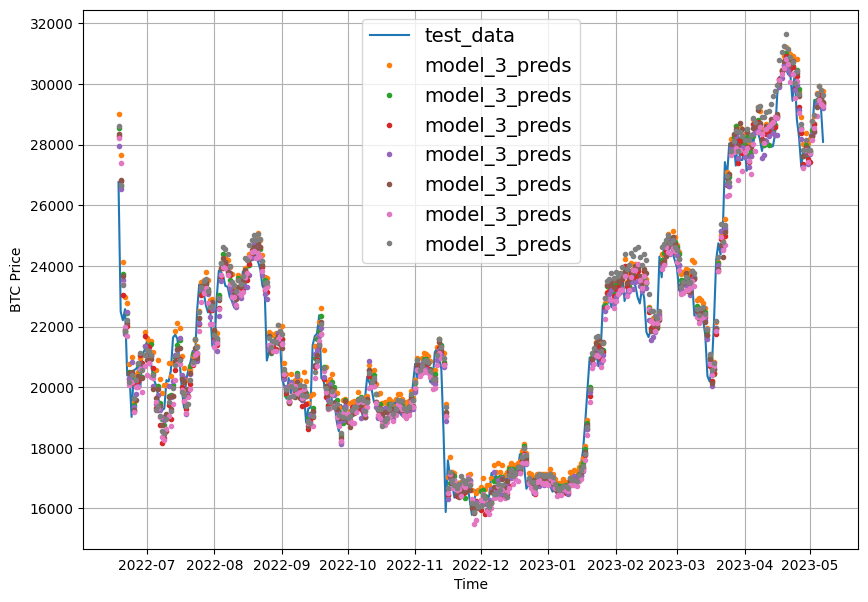

In [75]:
# Plot the model_3_preds
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 format="-",
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_3_preds,
                 start=offset,
                 label='model_3_preds')

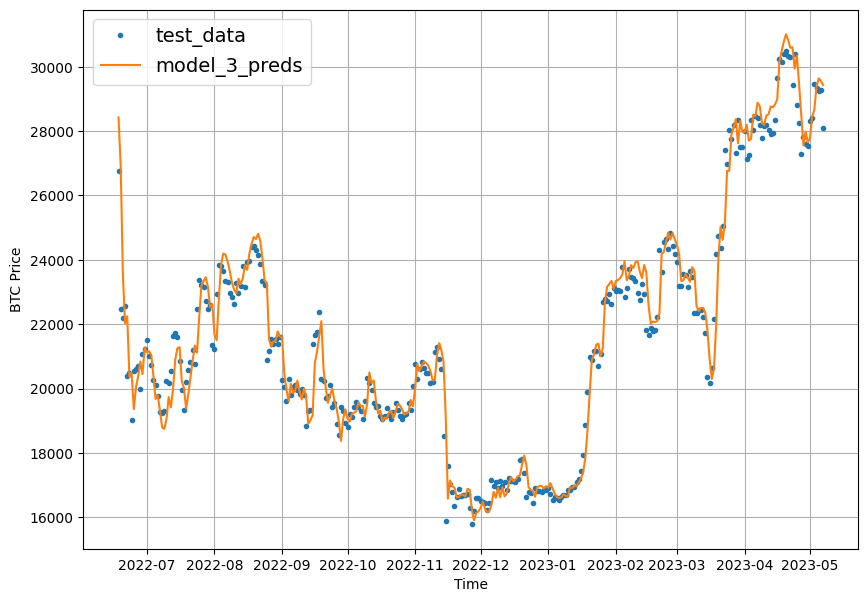

In [76]:
# Plot the model_3_preds - AGGREGATED VERSION 
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format="-",
                 label='model_3_preds')

## Which of our models performs the best so far?

<Axes: >

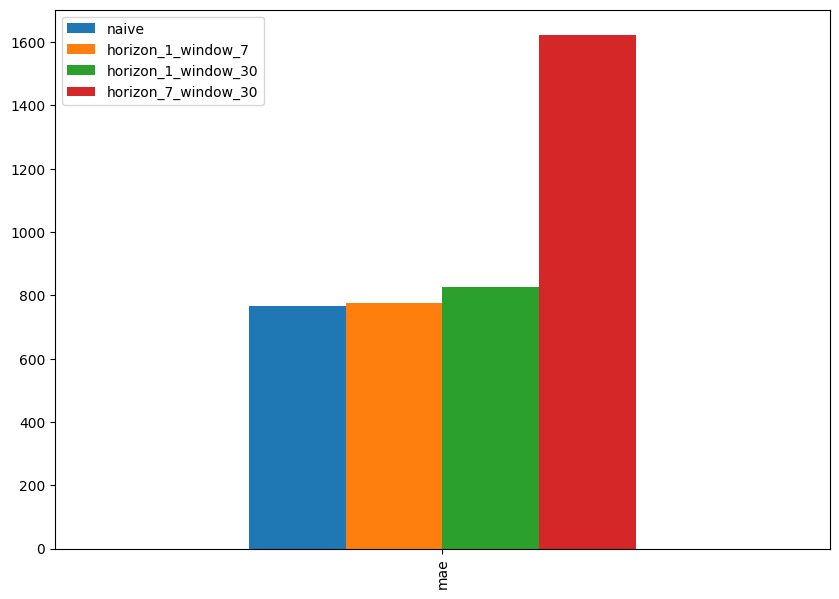

In [77]:
pd.DataFrame({'naive': naive_results['mae'],
              'horizon_1_window_7': model_1_results['mae'],
              'horizon_1_window_30': model_2_results['mae'],
              'horizon_7_window_30': model_3_results['mae']},
             index=['mae']).plot(figsize=(10,7), kind='bar')

## Model 4: Conv1D

In [78]:
HORIZON = 1 # predict next day...
WINDOW_SIZE = 7 # ...based on the week before

In [79]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(3148, 3148)

In [80]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, 
                                                                               full_labels,
                                                                               test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2518, 630, 2518, 630)

To use a Conv1D input layer, we need an input shape of `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet.

In [81]:
# Check data input shape
train_windows[0].shape

(7,)

In [82]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])>

In [83]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for input_dim

In [84]:
# Test out the Lambda layer
print(f"Original shape: {x.shape}") # WINDOW_SIZE
print(f"Expanded shape: {expand_dims_layer(x).shape}") # WINDOWS_SIZE, INPUT_DIM
print(f"Original values with expanded shape: {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape: [[457.334]
 [424.44 ]
 [394.796]
 [408.904]
 [398.821]
 [402.152]
 [435.791]]


In [85]:
# Create the Conv1D model
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128,
                  kernel_size=5,
                  strides=1,
                  padding='causal',
                  activation='relu'),
    layers.Dense(HORIZON)
], name='model_4_conv1D')

# Compile a model
model_4.compile(loss='mae',
                optimizer='adam',
                metrics=['mae', 'mse'])

# Fit the model
model_4.fit(x=train_windows,
            y=train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])


Epoch 1: val_loss improved from inf to 3252.37817, saving model to model_experiments/model_4_conv1D



Epoch 2: val_loss improved from 3252.37817 to 1685.08826, saving model to model_experiments/model_4_conv1D



Epoch 3: val_loss improved from 1685.08826 to 1605.10608, saving model to model_experiments/model_4_conv1D



Epoch 4: val_loss improved from 1605.10608 to 1547.72021, saving model to model_experiments/model_4_conv1D



Epoch 5: val_loss improved from 1547.72021 to 1400.40503, saving model to model_experiments/model_4_conv1D



Epoch 6: val_loss improved from 1400.40503 to 1344.05371, saving model to model_experiments/model_4_conv1D



Epoch 7: val_loss improved from 1344.05371 to 1338.02075, saving model to model_experiments/model_4_conv1D



Epoch 8: val_loss improved from 1338.02075 to 1330.82764, saving model to model_experiments/model_4_conv1D



Epoch 9: val_loss did not improve from 1330.82764

Epoch 10: val_loss improved from 1330.82764 to 1288.79529, saving model to model_experiments/model_4_conv1D



Epoch 11: val_loss improved from 1288.79529 to 1265.08484, saving model to model_experiments/model_4_conv1D



Epoch 12: val_loss did not improve from 1265.08484

Epoch 13: val_loss improved from 1265.08484 to 1252.89282, saving model to model_experiments/model_4_conv1D



Epoch 14: val_loss did not improve from 1252.89282

Epoch 15: val_loss improved from 1252.89282 to 1213.07239, saving model to model_experiments/model_4_conv1D



Epoch 16: val_loss improved from 1213.07239 to 1175.26636, saving model to model_experiments/model_4_conv1D



Epoch 17: val_loss did not improve from 1175.26636

Epoch 18: val_loss did not improve from 1175.26636

Epoch 19: val_loss improved from 1175.26636 to 1169.57568, saving model to model_experiments/model_4_conv1D



Epoch 20: val_loss did not improve from 1169.57568

Epoch 21: val_loss improved from 1169.57568 to 1139.40747, saving model to model_experiments/model_4_conv1D



Epoch 22: val_loss improved from 1139.40747 to 1113.11975, saving model to model_experiments/model_4_conv1D



Epoch 23: val_loss improved from 1113.11975 to 1046.06189, saving model to model_experiments/model_4_conv1D



Epoch 24: val_loss did not improve from 1046.06189

Epoch 25: val_loss did not improve from 1046.06189

Epoch 26: val_loss improved from 1046.06189 to 1037.01514, saving model to model_experiments/model_4_conv1D



Epoch 27: val_loss improved from 1037.01514 to 992.47577, saving model to model_experiments/model_4_conv1D



Epoch 28: val_loss improved from 992.47577 to 981.82379, saving model to model_experiments/model_4_conv1D



Epoch 29: val_loss did not improve from 981.82379

Epoch 30: val_loss improved from 981.82379 to 972.12543, saving model to model_experiments/model_4_conv1D



Epoch 31: val_loss improved from 972.12543 to 937.81555, saving model to model_experiments/model_4_conv1D



Epoch 32: val_loss did not improve from 937.81555

Epoch 33: val_loss improved from 937.81555 to 937.44873, saving model to model_experiments/model_4_conv1D



Epoch 34: val_loss improved from 937.44873 to 926.33093, saving model to model_experiments/model_4_conv1D



Epoch 35: val_loss improved from 926.33093 to 906.09167, saving model to model_experiments/model_4_conv1D



Epoch 36: val_loss did not improve from 906.09167

Epoch 37: val_loss did not improve from 906.09167

Epoch 38: val_loss did not improve from 906.09167

Epoch 39: val_loss improved from 906.09167 to 886.59387, saving model to model_experiments/model_4_conv1D



Epoch 40: val_loss improved from 886.59387 to 870.22687, saving model to model_experiments/model_4_conv1D



Epoch 41: val_loss did not improve from 870.22687

Epoch 42: val_loss did not improve from 870.22687

Epoch 43: val_loss did not improve from 870.22687

Epoch 44: val_loss did not improve from 870.22687

Epoch 45: val_loss improved from 870.22687 to 853.96893, saving model to model_experiments/model_4_conv1D



Epoch 46: val_loss did not improve from 853.96893

Epoch 47: val_loss did not improve from 853.96893

Epoch 48: val_loss did not improve from 853.96893

Epoch 49: val_loss improved from 853.96893 to 850.32538, saving model to model_experiments/model_4_conv1D



Epoch 50: val_loss improved from 850.32538 to 843.52112, saving model to model_experiments/model_4_conv1D



Epoch 51: val_loss did not improve from 843.52112

Epoch 52: val_loss did not improve from 843.52112

Epoch 53: val_loss did not improve from 843.52112

Epoch 54: val_loss improved from 843.52112 to 838.67120, saving model to model_experiments/model_4_conv1D



Epoch 55: val_loss did not improve from 838.67120

Epoch 56: val_loss did not improve from 838.67120

Epoch 57: val_loss improved from 838.67120 to 834.74792, saving model to model_experiments/model_4_conv1D



Epoch 58: val_loss did not improve from 834.74792

Epoch 59: val_loss improved from 834.74792 to 832.34454, saving model to model_experiments/model_4_conv1D



Epoch 60: val_loss improved from 832.34454 to 827.88074, saving model to model_experiments/model_4_conv1D



Epoch 61: val_loss did not improve from 827.88074

Epoch 62: val_loss did not improve from 827.88074

Epoch 63: val_loss did not improve from 827.88074

Epoch 64: val_loss did not improve from 827.88074

Epoch 65: val_loss did not improve from 827.88074

Epoch 66: val_loss did not improve from 827.88074

Epoch 67: val_loss did not improve from 827.88074

Epoch 68: val_loss did not improve from 827.88074

Epoch 69: val_loss did not improve from 827.88074

Epoch 70: val_loss improved from 827.88074 to 814.35529, saving model to model_experiments/model_4_conv1D



Epoch 71: val_loss did not improve from 814.35529

Epoch 72: val_loss did not improve from 814.35529

Epoch 73: val_loss did not improve from 814.35529

Epoch 74: val_loss did not improve from 814.35529

Epoch 75: val_loss did not improve from 814.35529

Epoch 76: val_loss did not improve from 814.35529

Epoch 77: val_loss did not improve from 814.35529

Epoch 78: val_loss did not improve from 814.35529

Epoch 79: val_loss did not improve from 814.35529

Epoch 80: val_loss did not improve from 814.35529

Epoch 81: val_loss did not improve from 814.35529

Epoch 82: val_loss did not improve from 814.35529

Epoch 83: val_loss did not improve from 814.35529

Epoch 84: val_loss did not improve from 814.35529

Epoch 85: val_loss did not improve from 814.35529

Epoch 86: val_loss improved from 814.35529 to 802.87274, saving model to model_experiments/model_4_conv1D



Epoch 87: val_loss did not improve from 802.87274

Epoch 88: val_loss did not improve from 802.87274

Epoch 89: val_loss did not improve from 802.87274

Epoch 90: val_loss improved from 802.87274 to 802.84070, saving model to model_experiments/model_4_conv1D



Epoch 91: val_loss improved from 802.84070 to 798.91748, saving model to model_experiments/model_4_conv1D



Epoch 92: val_loss did not improve from 798.91748

Epoch 93: val_loss did not improve from 798.91748

Epoch 94: val_loss did not improve from 798.91748

Epoch 95: val_loss did not improve from 798.91748

Epoch 96: val_loss did not improve from 798.91748

Epoch 97: val_loss improved from 798.91748 to 795.80042, saving model to model_experiments/model_4_conv1D



Epoch 98: val_loss did not improve from 795.80042

Epoch 99: val_loss did not improve from 795.80042

Epoch 100: val_loss did not improve from 795.80042


In [86]:
# Evaluate model_4
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 839.0519 - mae: 839.0519 - mse: 1589084.1250


[839.0518798828125, 839.0518798828125, 1589084.125]

In [87]:
# Load in the best performing model_4
model_4 = tf.keras.models.load_model('model_experiments/model_4_conv1D')
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 795.8004 - mae: 795.8004 - mse: 1474085.1250


[795.8003540039062, 795.8003540039062, 1474085.125]

In [88]:
# Make predictions 
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([47139.64 , 46361.383, 44827.133, 44726.01 , 46026.5  , 48661.66 ,
       49110.57 , 49496.88 , 49672.926, 48167.008], dtype=float32)>

In [89]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 795.8004,
 'mse': 1474085.4,
 'rmse': 1214.1191,
 'mape': 2.3439047,
 'mase': 1.0370153}

In [90]:
model_1_results

{'mae': 776.82983,
 'mse': 1422676.4,
 'rmse': 1192.76,
 'mape': 2.286696,
 'mase': 1.0122947}

## Model 5: LSTM
Let's create a RNN model for our time series data.

We're going to use the same data we have created for previous experiment.

In [91]:
# Let's create LSTM model using Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
#x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
#x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs, outputs, name='model_5_LSTM')

# Compile
model_5.compile(loss='mae',
                optimizer='adam')
                #metrics=['mae', 'mse'])

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])

Epoch 1/100
11/20 [===============>..............] - ETA: 0s - loss: 7420.2905 
Epoch 1: val_loss improved from inf to 15345.54492, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 4s 110ms/step - loss: 6435.9331 - val_loss: 15345.5449
Epoch 2/100
11/20 [===============>..............] - ETA: 0s - loss: 2875.7244
Epoch 2: val_loss improved from 15345.54492 to 3340.94604, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 2s 96ms/step - loss: 1916.7913 - val_loss: 3340.9460
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 654.0353
Epoch 3: val_loss improved from 3340.94604 to 1525.04724, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 2s 92ms/step - loss: 654.0353 - val_loss: 1525.0472
Epoch 4/100
17/20 [========================>.....] - ETA: 0s - loss: 455.0142
Epoch 4: val_loss improved from 1525.04724 to 1317.52625, saving model to model_experiments/

In [92]:
# Load in the best version of model_5 and evaluate
model_5 = tf.keras.models.load_model('model_experiments/model_5_LSTM')
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 823.0967


823.0966796875

In [93]:
# Make prediction 
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([47149.67 , 46607.1  , 45088.316, 44723.633, 45869.766],
      dtype=float32)>

In [94]:
# Evaluate model_5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                y_pred=model_5_preds)
model_5_results

{'mae': 823.0967,
 'mse': 1564016.5,
 'rmse': 1250.6064,
 'mape': 2.4236329,
 'mase': 1.0725853}

In [95]:
model_1_results

{'mae': 776.82983,
 'mse': 1422676.4,
 'rmse': 1192.76,
 'mape': 2.286696,
 'mase': 1.0122947}

## Make a multivariate time series data

Before we add feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...
* day 1 - 0
* day 2 - 1
* day 3 - 0 and so on

What's a better feature to use?

Maybe Bitcon halving events?

In [96]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [97]:
# Let's add Bitcoin halving events to our data
block_reward_1 = 50 # 3 Jan 2009 - this reward isn't in our dataset (start from 17/9/2014)
block_reward_2 = 25 # 28 Nov 2012 - this reward isn't in our dataset, too
block_reward_3 = 12.5 # 9 Jul 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [98]:
# Create date ranges where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(661, 2070)

In [99]:
# Add in block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

# Add in block_reward values as a feature to our dataframes
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2023-05-03,29006.308594,6.25
2023-05-04,28847.710938,6.25
2023-05-05,29534.384766,6.25
2023-05-06,28904.623047,6.25
2023-05-07,28897.636719,6.25


<Axes: xlabel='Date'>

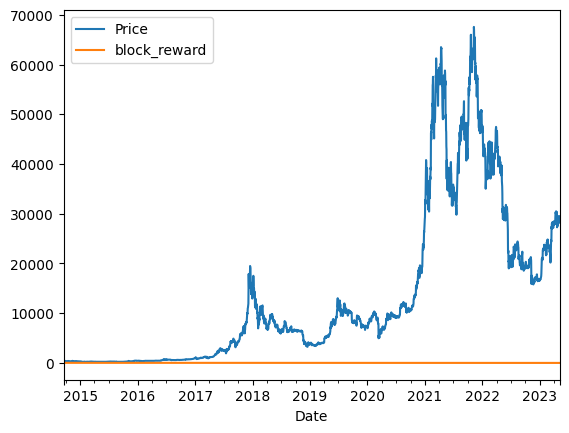

In [100]:
bitcoin_prices_block.plot()

<Axes: xlabel='Date'>

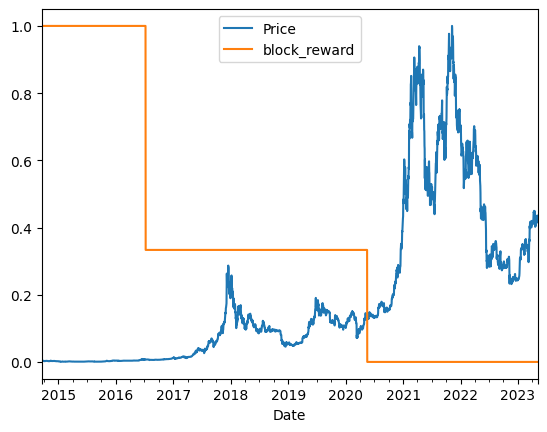

In [101]:
# Plot the block_reward vs price overtime
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot()

## Making a windowed dataset with `Pandas`
Previously we've turned our univariate time series into windowed dataset using helper functions above.

However, since we'ge got multivariate now, these functions won't work.

Not to worry, we can use the `pandas.DataFrame.shift()` method to window our multivariate data. 

In [102]:
# Setup hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [103]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): #shift values for each step in window size
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed['Price'].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,25,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,25,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,25,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,25,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


What we've done is create a way to window our dataset directly from a `pandas.DataFrame`.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
...
```

In [104]:
# Create X (windows) and y (horizon) features
X = bitcoin_prices_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)
X.head(), y.head()

(            block_reward     Price+1     Price+2     Price+3     Price+4  \
 Date                                                                       
 2014-09-24          25.0  435.790985  402.152008  398.821014  408.903992   
 2014-09-25          25.0  423.204987  435.790985  402.152008  398.821014   
 2014-09-26          25.0  411.574005  423.204987  435.790985  402.152008   
 2014-09-27          25.0  404.424988  411.574005  423.204987  435.790985   
 2014-09-28          25.0  399.519989  404.424988  411.574005  423.204987   
 
                Price+5     Price+6     Price+7  
 Date                                            
 2014-09-24  394.795990  424.440002  457.334015  
 2014-09-25  408.903992  394.795990  424.440002  
 2014-09-26  398.821014  408.903992  394.795990  
 2014-09-27  402.152008  398.821014  408.903992  
 2014-09-28  435.790985  402.152008  398.821014  ,
 Date
 2014-09-24    423.204987
 2014-09-25    411.574005
 2014-09-26    404.424988
 2014-09-27    399.51998

In [105]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2518, 630, 2518, 630)

In [106]:
X_train

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,25.00,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,25.00,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,25.00,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,25.00,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,25.00,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014
...,...,...,...,...,...,...,...,...
2021-08-11,6.25,45585.031250,46365.402344,43798.117188,44555.800781,42816.500000,40869.554688,39747.503906
2021-08-12,6.25,45593.636719,45585.031250,46365.402344,43798.117188,44555.800781,42816.500000,40869.554688
2021-08-13,6.25,44428.289062,45593.636719,45585.031250,46365.402344,43798.117188,44555.800781,42816.500000


## Model 6: Dense (but on multivariate data)

In [107]:
tf.random.set_seed(42)

# Make a multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_6_dense_multivariate')

# Compile the model
model_6.compile(loss='mae',
                optimizer='adam')

# Fit the model
model_6.fit(X_train,
            y_train,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_6.name)])

Epoch 1/100
18/20 [==========================>...] - ETA: 0s - loss: 1762.6542 
Epoch 1: val_loss improved from inf to 1373.82397, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 2s 41ms/step - loss: 1694.6376 - val_loss: 1373.8240
Epoch 2/100
18/20 [==========================>...] - ETA: 0s - loss: 501.9289
Epoch 2: val_loss improved from 1373.82397 to 1258.43457, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 34ms/step - loss: 494.1934 - val_loss: 1258.4346
Epoch 3/100
18/20 [==========================>...] - ETA: 0s - loss: 433.2313
Epoch 3: val_loss improved from 1258.43457 to 1246.23962, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 34ms/step - loss: 429.1543 - val_loss: 1246.2396
Epoch 4/100
19/20 [===========================>..] - ETA: 0s - loss: 407.3871
Epoch 4: val_loss improved from 1246.23962 to 1192.10242, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 33ms/step - loss: 408.6946 - val_loss: 1192.1024
Epoch 5/100
19/20 [===========================>..] - ETA: 0s - loss: 402.6108
Epoch 5: val_loss improved from 1192.10242 to 1035.63708, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 53ms/step - loss: 399.3267 - val_loss: 1035.6371
Epoch 6/100
17/20 [========================>.....] - ETA: 0s - loss: 360.8326
Epoch 6: val_loss did not improve from 1035.63708
20/20 [==============================] - 0s 5ms/step - loss: 370.1732 - val_loss: 1090.2433
Epoch 7/100
18/20 [==========================>...] - ETA: 0s - loss: 369.7779
Epoch 7: val_loss did not improve from 1035.63708
20/20 [==============================] - 0s 5ms/step - loss: 363.9500 - val_loss: 1212.5331
Epoch 8/100
19/20 [===========================>..] - ETA: 0s - loss: 345.7824
Epoch 8: val_loss improved from 1035.63708 to 951.41943, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 33ms/step - loss: 341.1062 - val_loss: 951.4194
Epoch 9/100
19/20 [===========================>..] - ETA: 0s - loss: 334.0907
Epoch 9: val_loss did not improve from 951.41943
20/20 [==============================] - 0s 5ms/step - loss: 330.0095 - val_loss: 981.9169
Epoch 10/100
18/20 [==========================>...] - ETA: 0s - loss: 310.3285
Epoch 10: val_loss improved from 951.41943 to 879.12006, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 33ms/step - loss: 311.1211 - val_loss: 879.1201
Epoch 11/100
13/20 [==================>...........] - ETA: 0s - loss: 317.1217
Epoch 11: val_loss improved from 879.12006 to 872.52350, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 35ms/step - loss: 320.1216 - val_loss: 872.5235
Epoch 12/100
13/20 [==================>...........] - ETA: 0s - loss: 320.7201
Epoch 12: val_loss did not improve from 872.52350
20/20 [==============================] - 0s 9ms/step - loss: 307.0034 - val_loss: 943.2008
Epoch 13/100
12/20 [=================>............] - ETA: 0s - loss: 299.3695
Epoch 13: val_loss did not improve from 872.52350
20/20 [==============================] - 0s 8ms/step - loss: 322.1521 - val_loss: 1249.6587
Epoch 14/100
12/20 [=================>............] - ETA: 0s - loss: 367.6375
Epoch 14: val_loss improved from 872.52350 to 868.78174, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 48ms/step - loss: 357.8314 - val_loss: 868.7817
Epoch 15/100
14/20 [====================>.........] - ETA: 0s - loss: 292.2682
Epoch 15: val_loss improved from 868.78174 to 835.81372, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 48ms/step - loss: 291.3856 - val_loss: 835.8137
Epoch 16/100
13/20 [==================>...........] - ETA: 0s - loss: 285.0177
Epoch 16: val_loss did not improve from 835.81372
20/20 [==============================] - 0s 7ms/step - loss: 284.9110 - val_loss: 877.7548
Epoch 17/100
13/20 [==================>...........] - ETA: 0s - loss: 294.6783
Epoch 17: val_loss did not improve from 835.81372
20/20 [==============================] - 0s 8ms/step - loss: 285.9561 - val_loss: 987.5113
Epoch 18/100
12/20 [=================>............] - ETA: 0s - loss: 286.1104
Epoch 18: val_loss improved from 835.81372 to 826.27997, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 47ms/step - loss: 280.6474 - val_loss: 826.2800
Epoch 19/100
13/20 [==================>...........] - ETA: 0s - loss: 269.8113
Epoch 19: val_loss did not improve from 826.27997
20/20 [==============================] - 0s 7ms/step - loss: 275.5580 - val_loss: 1294.7336
Epoch 20/100
12/20 [=================>............] - ETA: 0s - loss: 347.6892
Epoch 20: val_loss did not improve from 826.27997
20/20 [==============================] - 0s 7ms/step - loss: 345.4421 - val_loss: 928.3169
Epoch 21/100
13/20 [==================>...........] - ETA: 0s - loss: 357.1518
Epoch 21: val_loss did not improve from 826.27997
20/20 [==============================] - 0s 6ms/step - loss: 324.3701 - val_loss: 829.8636
Epoch 22/100
19/20 [===========================>..] - ETA: 0s - loss: 287.6207
Epoch 22: val_loss did not improve from 826.27997
20/20 [==============================] - 0s 5ms/step - loss: 289.8336 - val_loss: 1011.0414
Epoch 23/100
19/20 [======

20/20 [==============================] - 1s 33ms/step - loss: 277.3281 - val_loss: 789.3399
Epoch 30/100
18/20 [==========================>...] - ETA: 0s - loss: 269.3547
Epoch 30: val_loss improved from 789.33990 to 788.78583, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 34ms/step - loss: 269.9775 - val_loss: 788.7858
Epoch 31/100
19/20 [===========================>..] - ETA: 0s - loss: 274.1671
Epoch 31: val_loss did not improve from 788.78583
20/20 [==============================] - 0s 5ms/step - loss: 274.1755 - val_loss: 791.7430
Epoch 32/100
18/20 [==========================>...] - ETA: 0s - loss: 264.6338
Epoch 32: val_loss did not improve from 788.78583
20/20 [==============================] - 0s 5ms/step - loss: 268.0056 - val_loss: 820.1179
Epoch 33/100
19/20 [===========================>..] - ETA: 0s - loss: 271.8415
Epoch 33: val_loss did not improve from 788.78583
20/20 [==============================] - 0s 5ms/step - loss: 270.5954 - val_loss: 811.2294
Epoch 34/100
19/20 [===========================>..] - ETA: 0s - loss: 266.6933
Epoch 34: val_loss improved from 788.78583 to 787.79810, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 33ms/step - loss: 269.2392 - val_loss: 787.7981
Epoch 35/100
19/20 [===========================>..] - ETA: 0s - loss: 279.5717
Epoch 35: val_loss did not improve from 787.79810
20/20 [==============================] - 0s 5ms/step - loss: 279.1730 - val_loss: 819.1804
Epoch 36/100
16/20 [=======================>......] - ETA: 0s - loss: 259.1388
Epoch 36: val_loss improved from 787.79810 to 784.65491, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 35ms/step - loss: 267.8754 - val_loss: 784.6549
Epoch 37/100
18/20 [==========================>...] - ETA: 0s - loss: 263.6584
Epoch 37: val_loss did not improve from 784.65491
20/20 [==============================] - 0s 5ms/step - loss: 264.1905 - val_loss: 803.7782
Epoch 38/100
19/20 [===========================>..] - ETA: 0s - loss: 260.4669
Epoch 38: val_loss did not improve from 784.65491
20/20 [==============================] - 0s 5ms/step - loss: 266.6960 - val_loss: 786.0622
Epoch 39/100
18/20 [==========================>...] - ETA: 0s - loss: 269.7450
Epoch 39: val_loss did not improve from 784.65491
20/20 [==============================] - 0s 6ms/step - loss: 273.4069 - val_loss: 874.8526
Epoch 40/100
19/20 [===========================>..] - ETA: 0s - loss: 302.0409
Epoch 40: val_loss did not improve from 784.65491
20/20 [==============================] - 0s 5ms/step - loss: 304.7136 - val_loss: 843.8012
Epoch 41/100
19/20 [========

20/20 [==============================] - 1s 32ms/step - loss: 264.9599 - val_loss: 779.7522
Epoch 49/100
18/20 [==========================>...] - ETA: 0s - loss: 302.0897
Epoch 49: val_loss did not improve from 779.75220
20/20 [==============================] - 0s 5ms/step - loss: 297.1710 - val_loss: 949.9496
Epoch 50/100
14/20 [====================>.........] - ETA: 0s - loss: 255.1883
Epoch 50: val_loss did not improve from 779.75220
20/20 [==============================] - 0s 6ms/step - loss: 265.8554 - val_loss: 838.9191
Epoch 51/100
19/20 [===========================>..] - ETA: 0s - loss: 270.4940
Epoch 51: val_loss did not improve from 779.75220
20/20 [==============================] - 0s 5ms/step - loss: 272.0425 - val_loss: 909.4407
Epoch 52/100
16/20 [=======================>......] - ETA: 0s - loss: 274.5132
Epoch 52: val_loss did not improve from 779.75220
20/20 [==============================] - 0s 6ms/step - loss: 276.8251 - val_loss: 838.3705
Epoch 53/100
14/20 [========

20/20 [==============================] - 1s 34ms/step - loss: 275.6703 - val_loss: 776.4987
Epoch 58/100
18/20 [==========================>...] - ETA: 0s - loss: 278.7294
Epoch 58: val_loss did not improve from 776.49872
20/20 [==============================] - 0s 5ms/step - loss: 276.6383 - val_loss: 901.7767
Epoch 59/100
19/20 [===========================>..] - ETA: 0s - loss: 273.7715
Epoch 59: val_loss did not improve from 776.49872
20/20 [==============================] - 0s 5ms/step - loss: 275.5276 - val_loss: 790.9056
Epoch 60/100
17/20 [========================>.....] - ETA: 0s - loss: 262.9897
Epoch 60: val_loss improved from 776.49872 to 775.44513, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 33ms/step - loss: 270.9182 - val_loss: 775.4451
Epoch 61/100
19/20 [===========================>..] - ETA: 0s - loss: 257.8394
Epoch 61: val_loss did not improve from 775.44513
20/20 [==============================] - 0s 5ms/step - loss: 261.6763 - val_loss: 808.5075
Epoch 62/100
16/20 [=======================>......] - ETA: 0s - loss: 269.0218
Epoch 62: val_loss did not improve from 775.44513
20/20 [==============================] - 0s 6ms/step - loss: 268.0809 - val_loss: 878.1647
Epoch 63/100
17/20 [========================>.....] - ETA: 0s - loss: 263.6134
Epoch 63: val_loss did not improve from 775.44513
20/20 [==============================] - 0s 5ms/step - loss: 279.9678 - val_loss: 1061.1376
Epoch 64/100
19/20 [===========================>..] - ETA: 0s - loss: 319.2667
Epoch 64: val_loss did not improve from 775.44513
20/20 [==============================] - 0s 5ms/step - loss: 320.5501 - val_loss: 923.5789
Epoch 65/100
19/20 [=======

20/20 [==============================] - 1s 34ms/step - loss: 264.0127 - val_loss: 775.0671
Epoch 72/100
14/20 [====================>.........] - ETA: 0s - loss: 272.4448
Epoch 72: val_loss did not improve from 775.06714
20/20 [==============================] - 0s 6ms/step - loss: 268.6391 - val_loss: 857.0766
Epoch 73/100
15/20 [=====================>........] - ETA: 0s - loss: 306.1292
Epoch 73: val_loss did not improve from 775.06714
20/20 [==============================] - 0s 7ms/step - loss: 301.0459 - val_loss: 809.2922
Epoch 74/100
13/20 [==================>...........] - ETA: 0s - loss: 273.3750
Epoch 74: val_loss did not improve from 775.06714
20/20 [==============================] - 0s 7ms/step - loss: 276.6319 - val_loss: 777.1577
Epoch 75/100
13/20 [==================>...........] - ETA: 0s - loss: 263.2379
Epoch 75: val_loss did not improve from 775.06714
20/20 [==============================] - 0s 9ms/step - loss: 265.9169 - val_loss: 979.5665
Epoch 76/100
14/20 [========

20/20 [==============================] - 1s 50ms/step - loss: 320.0485 - val_loss: 773.9395
Epoch 81/100
12/20 [=================>............] - ETA: 0s - loss: 286.5017
Epoch 81: val_loss did not improve from 773.93951
20/20 [==============================] - 0s 8ms/step - loss: 281.5038 - val_loss: 857.3921
Epoch 82/100
13/20 [==================>...........] - ETA: 0s - loss: 317.2108
Epoch 82: val_loss did not improve from 773.93951
20/20 [==============================] - 0s 7ms/step - loss: 300.5262 - val_loss: 784.1325
Epoch 83/100
14/20 [====================>.........] - ETA: 0s - loss: 271.5813
Epoch 83: val_loss did not improve from 773.93951
20/20 [==============================] - 0s 7ms/step - loss: 267.9195 - val_loss: 781.2324
Epoch 84/100
13/20 [==================>...........] - ETA: 0s - loss: 266.5370
Epoch 84: val_loss did not improve from 773.93951
20/20 [==============================] - 0s 7ms/step - loss: 262.5973 - val_loss: 796.7952
Epoch 85/100
14/20 [========

20/20 [==============================] - 1s 48ms/step - loss: 268.1560 - val_loss: 772.8925
Epoch 86/100
13/20 [==================>...........] - ETA: 0s - loss: 269.7378
Epoch 86: val_loss did not improve from 772.89246
20/20 [==============================] - 0s 7ms/step - loss: 261.4624 - val_loss: 872.6509
Epoch 87/100
13/20 [==================>...........] - ETA: 0s - loss: 267.1945
Epoch 87: val_loss did not improve from 772.89246
20/20 [==============================] - 0s 7ms/step - loss: 275.7971 - val_loss: 773.8084
Epoch 88/100
18/20 [==========================>...] - ETA: 0s - loss: 317.5386
Epoch 88: val_loss did not improve from 772.89246
20/20 [==============================] - 0s 5ms/step - loss: 310.7094 - val_loss: 874.4372
Epoch 89/100
 1/20 [>.............................] - ETA: 0s - loss: 282.1266
Epoch 89: val_loss did not improve from 772.89246
20/20 [==============================] - 0s 4ms/step - loss: 279.4082 - val_loss: 916.3736
Epoch 90/100
16/20 [========

In [108]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 840.7640


840.7639770507812

In [109]:
# Load best performing model
model_6 = tf.keras.models.load_model('model_experiments/model_6_dense_multivariate')
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 772.8925


772.8925170898438

In [110]:
# Make predictions
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

20/20 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([47184.81 , 46004.38 , 44677.04 , 44734.41 , 46376.83 , 49099.56 ,
       49073.074, 49371.92 , 49459.39 , 47890.277], dtype=float32)>

In [111]:
# Evaluate predictions to get metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 772.8926,
 'mse': 1409191.0,
 'rmse': 1187.0935,
 'mape': 2.277414,
 'mase': 1.0071639}

In [112]:
model_1_results

{'mae': 776.82983,
 'mse': 1422676.4,
 'rmse': 1192.76,
 'mape': 2.286696,
 'mase': 1.0122947}

In [113]:
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

## Model 7: N-BEATS algorithm
Let's now try andbuild the biggest, baddest time series forecasting model we've built so far.

More specifically, we'll be replicating the algo from the paper's figure 1:
https://arxiv.org/pdf/1905.10437.pdf

Why?
* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow subclassing to make our own custom layers
* We will get experiance using the Functional API to create custom architecture
* Potintially get state-of-the-art results and beat the Naive forecast 

### Building and testing the N-BEATS block layer

Because N-BEATS block layer does not exist in TensorFlow, we need to create it.

To create custom layers and models, we can use subclassing:
https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [114]:
# Create N-BEATS block custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__ (self, 
                input_size: int,
                theta_size: int,
                horizon: int,
                n_neurons: int,
                n_layers: int,
                **kwargs): # the keyword args argument takces care of all the parent args (input_size etc.)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 FC layers, each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
    
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')

  def call(self, inputs): # 'call' function is obligatory when inhereting from Layer class
    x = inputs
    for layer in self.hidden:
      x = layer(x)

    theta = self.theta_layer(x)

    # Output - backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

LEt's test our N-BEATS block class. To do so, we'll make some dummy inputs and outputs.

In [115]:
# Setup dummy N-BEATS block layer to represent inputs and outputs
tf.random.set_seed(42)

dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast and forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [116]:
# Create dummy inputs (have to be the same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE + 1), axis=0) # input shape has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [117]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are going to be activation outputs of the theta layer (random due to no training)
print(f"Backcast: \n{tf.squeeze(backcast).numpy()},\n\nForecast:\n {tf.squeeze(forecast).numpy()}")

Backcast: 
[-0.23625562 -0.3143073  -0.1745228  -0.20433405 -0.09410924  0.04034835
  0.57847565],

Forecast:
 -0.17349623143672943


### Preparing data for N-BEATS algorithm using `tf.data` API

To make our input data load as fast as possible, we're going to be adhearing to the performant data pipeline steps in the tf.data guide.

In [118]:
WINDOW_SIZE = 7
HORIZON = 1

In [119]:
# Create NBEATS data inputs (N-BEATS with univariate time series)
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-05-03,29006.308594
2023-05-04,28847.710938
2023-05-05,29534.384766


In [120]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats['Price'].shift(periods=i+1)

bitcoin_prices_nbeats.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-17,457.334015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


In [121]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop('Price', axis=1)
y = bitcoin_prices_nbeats.dropna()['Price']

# Make test/train sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2518, 630, 2518, 630)

In [122]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm
The N-BEATS has a few fair number of parameters, many of them can be found in the Table 18 of the paper mentioned earlier.

In [123]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for the residual connections
Before we can craft our N-BEATS model, we need two layers for the residual connectsions - substract and add.

N-BEATS uses double residual stacking to help train its deeper architecture (section 3.2 in paper). 

In [124]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Substract
subtracted = layers.Subtract()([tensor_1, tensor_2])

# Add
added = layers.Add()([tensor_1, tensor_2])

# Results
subtracted, added

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28], dtype=int32)>)

### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of `NBeatsBlock()` subclass layer (this'll be the initial block used for the network, the rest will be created as a part of stacks).
2. Create an input layer for the N-BEATS stack (we'll be using the `Keras Functional API`. 
3. Make the initial backcast and forecast for the model with the layer created in (1).
4. Use `for()` loop to create stack of block layers.
5. Use `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts.
6. Create the double residual stacking using `layers.subtract` and `layers.add`.
7. Put the model inputs and outputs together using `tf.keras.Model`.
8. Compile the model with MAE loss function (to keep it in line with previous experiments) and `Adam` optimizer with default settings as per section 5.2 of the paper.
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so long, we'll use a couple of callbacks:
  * `EarlyStopping` - because the model will fit so long, we'll stop it early if it stops improving
  * `ReduceLRonPlateau` - if a model stops improving, try lowering the learning rate to reduce the amount it improves on its weights each time (take smaller steps towards best performance)

In [125]:
%%time

tf.random.set_seed(42)

# 1. Setup an instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name='InitialBlock')

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name='stack_input')

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack already created in 3.

  # 5. Use the N-BEATS block to calculate backcast and forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f'subtract_{i}')
  forecast = layers.add([forecast, block_forecast], name=f'add_{i}')

# 7. Put together inputs and outputs of our stack
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name='model_7_nbeats')

# 8. Compile model with MAE loss
model_7.compile(loss='mae',
                optimizer='adam')

# 9. Fit the model with EarlyStopping on ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                            patience=100,
                                                            verbose=1)])

Epoch 1/5000
3/3 [==============================] - 55s 884ms/step - loss: 2123.7280 - val_loss: 27759.9434 - lr: 0.0010
Epoch 2/5000
3/3 [==============================] - 0s 77ms/step - loss: 5922.4204 - val_loss: 55676.1016 - lr: 0.0010
Epoch 3/5000
3/3 [==============================] - 0s 133ms/step - loss: 16376.3555 - val_loss: 6097.3447 - lr: 0.0010
Epoch 4/5000
3/3 [==============================] - 0s 62ms/step - loss: 1110.5270 - val_loss: 14922.0303 - lr: 0.0010
Epoch 5/5000
3/3 [==============================] - 0s 63ms/step - loss: 5617.5815 - val_loss: 14478.4111 - lr: 0.0010
Epoch 6/5000
3/3 [==============================] - 0s 62ms/step - loss: 2216.4043 - val_loss: 9918.8564 - lr: 0.0010
Epoch 7/5000
3/3 [==============================] - 0s 62ms/step - loss: 4213.5142 - val_loss: 10652.6504 - lr: 0.0010
Epoch 8/5000
3/3 [==============================] - 0s 68ms/step - loss: 1823.8784 - val_loss: 13222.1572 - lr: 0.0010
Epoch 9/5000
3/3 [============================

In [126]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 99ms/step - loss: 781.3535


781.353515625

In [127]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 3s 3s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([47198.33 , 46076.086, 44739.164, 44744.508, 46400.79 , 49119.613,
       49092.223, 49378.918, 49528.08 , 48020.387], dtype=float32)>

In [128]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 781.3535,
 'mse': 1430781.5,
 'rmse': 1196.1527,
 'mape': 2.3009093,
 'mase': 1.0181894}

In [129]:
model_1_results

{'mae': 776.82983,
 'mse': 1422676.4,
 'rmse': 1192.76,
 'mape': 2.286696,
 'mase': 1.0122947}

In [130]:
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

### Plotting the N-BEATS architecture we've created

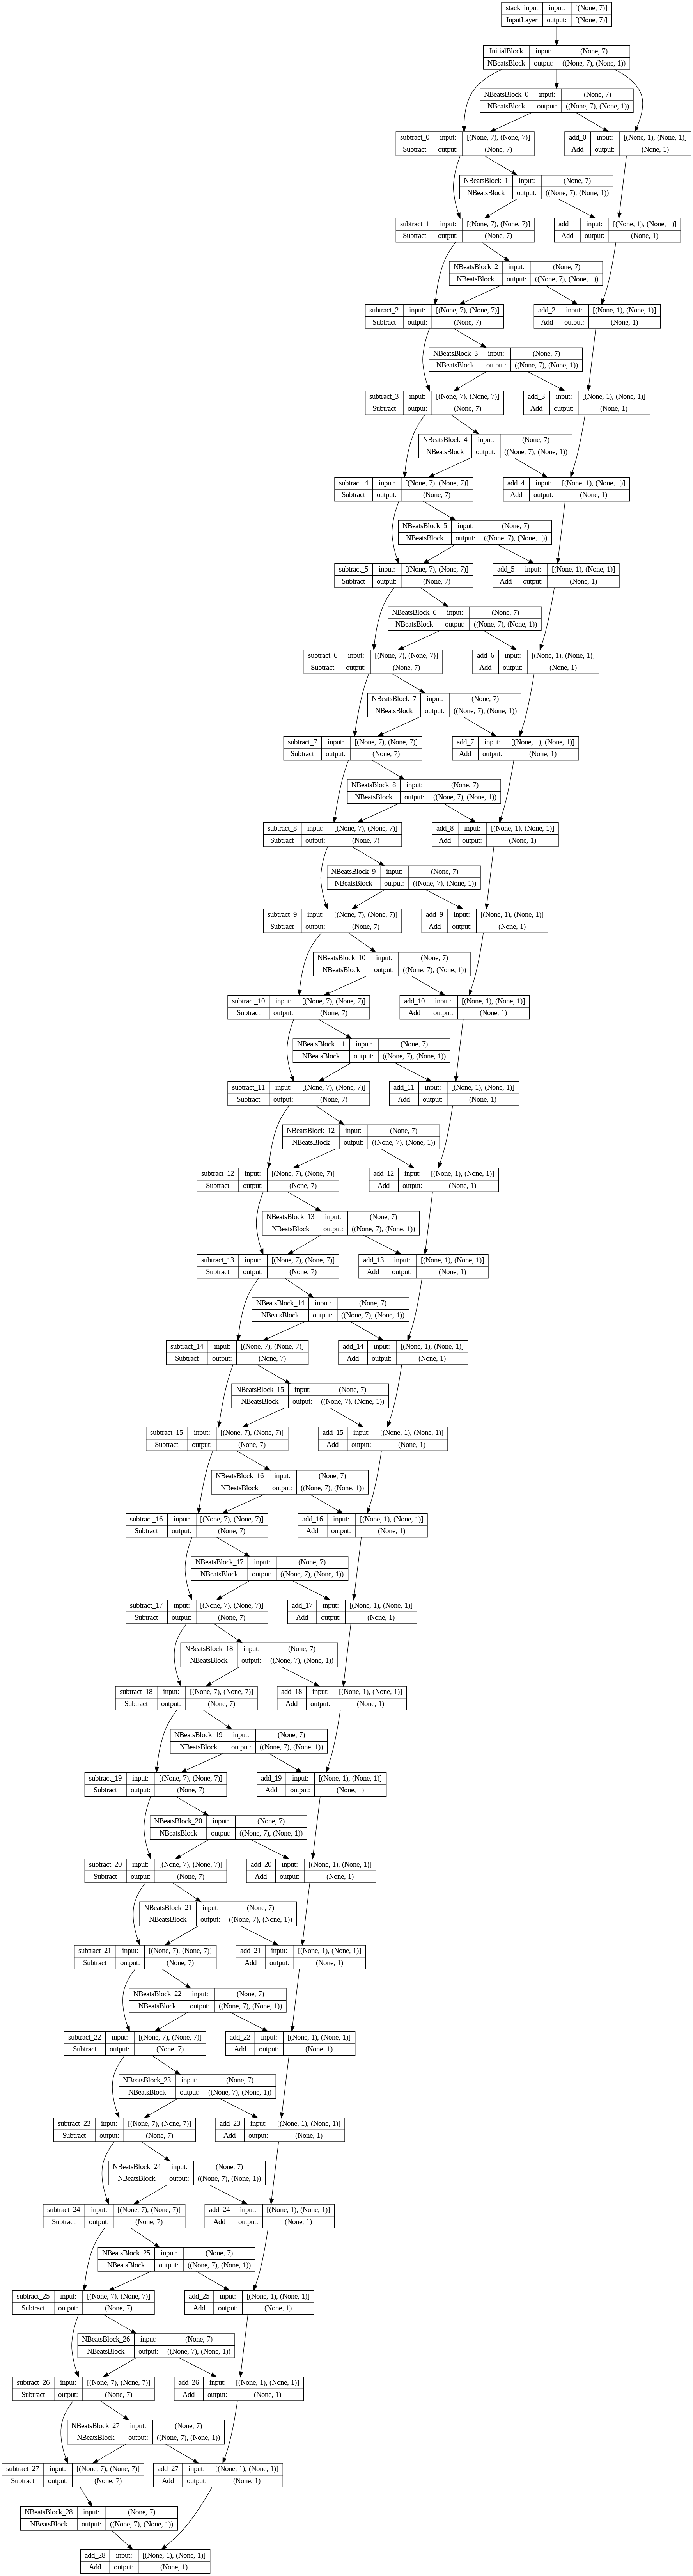

In [131]:
# Plot the N-BEATS model
tf.keras.utils.plot_model(model_7,
                          show_shapes=True,
                          show_layer_activations=True)

## Model 8: Creating an ensemble (Stacking different models together)
As ensemble leverages *the wisdom of the crowd* effect. It combines many **different** models to predict a common goal.

In [132]:
# A small reminder
HORIZON, WINDOW_SIZE

(1, 7)

### Constructing and fitting an ensemble of models (use different loss functions)

In [133]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=['mae', 'mse', 'mape']):
  """
  Returns a list of num_iter models each trained on MAE, MSE, MAPE loss metrics.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(loss_fn)
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          # Initialize Dense layers with normal distribution for estimating prediction intervals later on
          layers.Dense(128, kernel_initializer='he_normal', activation='relu'), # kernal initializer tells what kind of patterns should the optimizer start with
          layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
          layers.Dense(HORIZON)
      ], name=f"model_{i}_{loss_function}")

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['mae', 'mse'])

      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)
  
  return ensemble_models

In [134]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing mae for 1000 epochs, model number: 0

Epoch 880: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 980: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing mse for 1000 epochs, model number: 0
Optimizing model by reducing mape for 1000 epochs, model number: 0

Epoch 172: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 277: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 377: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing mae for 1000 epochs, model number: 1
Optimizing model by reducing mse for 1000 epochs, model number: 1

Epoch 376: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 476: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing mape for 1000 epochs, model number: 1

Epoch 221: ReduceLROnPlateau reducing lea

In [135]:
# Check the length
len(ensemble_models)

15

### Make predictions with our ensemble models

In [136]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []

  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  
  return tf.constant(tf.squeeze(ensemble_preds))

In [137]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 39ms/step
CPU times: user 690 ms, sys: 33.7 ms, total: 724 ms
Wall time: 854 ms


<tf.Tensor: shape=(15, 630), dtype=float32, numpy=
array([[47120.945, 46055.6  , 44756.477, ..., 28785.566, 29650.7  ,
        28880.873],
       [47306.195, 45976.09 , 44767.84 , ..., 28959.246, 29457.781,
        28993.484],
       [46907.   , 45932.64 , 44250.99 , ..., 28701.73 , 29493.383,
        28891.844],
       ...,
       [47093.637, 46718.867, 44886.816, ..., 29020.807, 29851.24 ,
        29203.488],
       [46657.16 , 46435.023, 44274.75 , ..., 28720.107, 29504.33 ,
        28926.406],
       [47071.566, 46250.93 , 44597.332, ..., 28851.209, 29600.086,
        28947.662]], dtype=float32)>

In [138]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds)
ensemble_results

{'mae': 796.30133,
 'mse': 1466004.2,
 'rmse': 1210.5236,
 'mape': 2.3464763,
 'mase': 1.0376682}

In [139]:
# Check for different possibilities of combining ensemble predictions
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_median = np.median(ensemble_preds, axis=0)

In [140]:
# Ensemble results for both metrics
ensemble_results_mean = evaluate_preds(y_test, ensemble_mean)
ensemble_results_median = evaluate_preds(y_test, ensemble_median)
ensemble_results_median, ensemble_results_mean

({'mae': 772.5716,
  'mse': 1412466.6,
  'rmse': 1188.4724,
  'mape': 2.2685592,
  'mase': 1.0067457},
 {'mae': 775.6229,
  'mse': 1416196.6,
  'rmse': 1190.0405,
  'mape': 2.2788024,
  'mase': 1.0107219})

### Plotting the prediction intervals (uncertainty estimates) of our ensemble
So far we've been making point predictions with our models. 

E.g. horizon = 1, our model predicts tomorrow price of BTC will be $50.000 USD. 

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of $50.000 USD on the dot, how about 48.000-52.000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the boostrap method:
1. Take the predictions from a number of randomly initialized models (we do have that from our ensemble models).
2. Measure the standard deviation of the predictions.
3. Multiply the standard deviation by 1.96 (assuming the distribution of our data is Gaussian/Normal, 95% of observsations fall within 1.96 standard deviations of the mean).
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1).

Materials:
https://en.wikipedia.org/wiki/97.5th_percentile_point

In [141]:
# Find the upper and lower bands of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly initialized models

  # 2. Measure the standard deviation of the predicitons
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [142]:
# Get the upper and lower bounds of 95% prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)
lower[:10], upper[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([46560.742, 45558.562, 44081.5  , 44262.355, 46084.863, 48866.02 ,
        48749.945, 48955.977, 49026.773, 47299.332], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([47526.477, 46822.477, 45085.71 , 45301.69 , 46972.38 , 49865.066,
        49699.67 , 49956.11 , 50214.32 , 48448.76 ], dtype=float32)>)

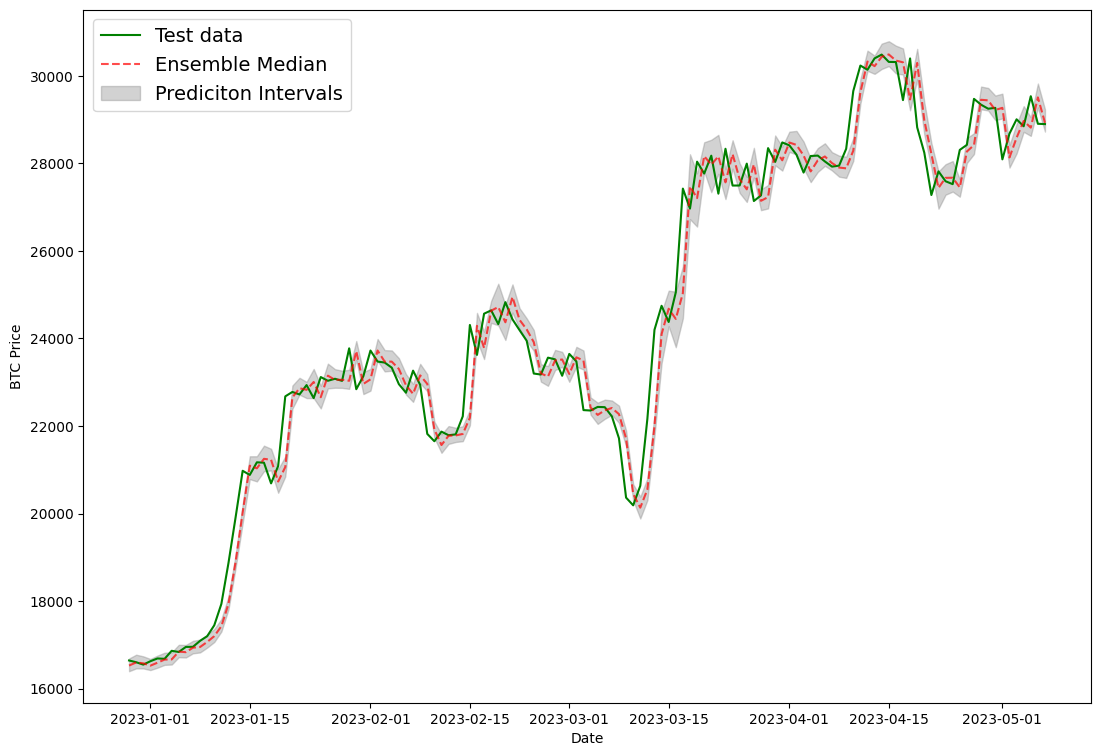

In [143]:
# Get the median/mean values of our ensemble_preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediciton intervals (where the predictions fall between)
offset = 500

plt.figure(figsize=(13,9))

plt.plot(X_test.index[offset:],
         y_test[offset:],
         color='green',
         label='Test data')

plt.plot(X_test.index[offset:],
         ensemble_median[offset:],
         '--',
         color='red',
         alpha=0.7,
         label='Ensemble Median')

plt.xlabel('Date')
plt.ylabel('BTC Price')

# To plot the bounds, lets use fill_between
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:],
                 label="Prediciton Intervals",
                 color='grey',
                 alpha=0.35)
plt.legend(loc='upper left',
           fontsize=14)

So far all of our models prediction have been lagging behind the test data as if they were replicating what the naive model does and just predict the previous timestep as the nex timestep.

> **NOTE:** These prediction intervals are predicitons themselves and have been created with an assumption that our model's data is from a normal distribution.

## Aside: two types of uncertainity (coconut and subway)

## Model 9: Future prediction model (trained on the full historical data avaliable)

So far all of our models have predicted on the test dataset (so pseudo-future data), however this not enough.

Let's now build a model which is capable of predicting into the future!

In [155]:
HORIZON = 1
WINDOW_SIZE = 7

In [156]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN


In [157]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2023-05-03,29006.308594,6.25,28680.537109,28091.568359,29268.806641,29248.488281,29340.261719,29473.787109,28422.701172
2023-05-04,28847.710938,6.25,29006.308594,28680.537109,28091.568359,29268.806641,29248.488281,29340.261719,29473.787109
2023-05-05,29534.384766,6.25,28847.710938,29006.308594,28680.537109,28091.568359,29268.806641,29248.488281,29340.261719
2023-05-06,28904.623047,6.25,29534.384766,28847.710938,29006.308594,28680.537109,28091.568359,29268.806641,29248.488281
2023-05-07,28897.636719,6.25,28904.623047,29534.384766,28847.710938,29006.308594,28680.537109,28091.568359,29268.806641


In [158]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.dropna().drop(['Price', 'block_reward'], axis=1).to_numpy()
y_all = bitcoin_prices_windowed.dropna()['Price'].to_numpy()
len(X_all), len(y_all)

(3148, 3148)

In [159]:
# Turn data info efficient tensors with tf.data API
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [160]:
tf.random.set_seed(42)

# Create a model
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_9_future_model')

# Compile
model_9.compile(loss='mae',
                optimizer='adam')

# Fit on all of the data
model_9.fit(dataset_all,
            epochs=100,
            verbose=0,
            callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('model_experiments', model_9.name),
                                                          monitor='loss',
                                                          save_weights_only=True,
                                                          verbose=0)])

model_9

### Make prediction into the future